In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/Kolmogorov


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, readAndReturnLossHistories
from tools.ae_v2 import Autoencoder
from tools.ConvESN_v3 import ESN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2023-02-20 02:08:28.741378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 02:08:28.741768: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 02:08:28.796123: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 02:08:28.796428: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 02:08:28.796674: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


UMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 02:08:29.523360: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 02:08:29.523603: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 02:08:29.523802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 02:08:29.523971: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3369 MB memory:  -> device: 1, name: Quadro K2200, pci bus id: 0000:03

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
# from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_ConvESN'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'ESN_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')
    
    # whether to use AE data or just work on raw data
    use_ae_data = True # if false, specifying ae_idx will only show which dataset to use
    
    # autoencoder directory
    ae_idx = '013'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_ConvESN/ESN_008'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    use_ae_data = params_dict['use_ae_data']
    
    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    

    normalization_arr = None
    try:
        with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
            lines = f.readlines()
        rnn_norm_arr_dict = eval(lines)
        normalization_arr = rnn_norm_arr_dict['normalization_arr']
    except:
        pass
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_arr = fl['normalization_arr'][0]

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']

with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
    normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx

with h5py.File(dir_name_data + '/data.h5', 'r') as f:
    t_recorded_samples = np.array(f['t'])
    
    N = int(0.5*(np.array(f['num_wavenumbers'])-1))
    print(N, type(N))
    
    u_ref = np.array(f['u_reference'], dtype=FTYPE)
    v_ref = np.array(f['v_reference'], dtype=FTYPE)

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_013
data_dir_idx: 000
24 <class 'int'>


In [13]:
all_data = np.empty(shape=(u_ref.shape[0], 2, u_ref.shape[1], u_ref.shape[2]), dtype=FTYPE)
all_data[:, 0, :, :] = u_ref
del(u_ref)
all_data[:, 1, :, :] = v_ref
del(v_ref)

In [14]:
delta_t = 1.
T = t_recorded_samples[-1]

In [15]:
# delaing with normalizing the data before feeding into autoencoder
if use_ae_data == True:
    if normalizeforae_flag == True:
        all_data -= normalization_constant_arr_aedata[0]
        all_data /= normalization_constant_arr_aedata[1]

In [16]:
print('all_data.shape : {}'.format(all_data.shape))

all_data.shape : (100001, 2, 50, 50)


In [17]:
all_data = all_data[0:int(all_data.shape[0]/3)]

In [18]:
print('all_data.shape : {}'.format(all_data.shape))

all_data.shape : (33333, 2, 50, 50)


# Autoencoder

In [19]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [20]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1:], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

2023-02-20 02:08:35.278070: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401


In [21]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    del(all_data)
else:
    latent_states_all = all_data
# num_latent_states = latent_states_all.shape[1]

In [22]:
temp_ = latent_states_all.reshape(latent_states_all.shape[0], -1)
time_stddev_AEproducedlatentstates = np.std(temp_, axis=0)

# ESN

In [23]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    dt_rnn = 0.25
    num_input_tsteps = 100
    T_sample_input = num_input_tsteps*dt_rnn
    T_sample_output = T_sample_input
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    normalization_arr = None
    stddev_multiplier = 3
    skip_intermediate = 'full sample'
    noise_type = 'normal' # can be 'uniform' or 'normal'
    normalization_type = 'stddev' # can be 'minmax' or 'stddev', if it is
                                  # 'minmax' then stddev_multiplier has no effect
    res_channels = 200
    kernel_size = 5#ae_net.kernel_size
    stateful = True
    omega_in = 1.0
    rho_res = 0.6
    usebias_Win = False
    alpha = 0.99
    ESN_cell_activations = 'tanh'
    usebias_Wout = True
    
    # saving simulation data
    sim_data = {
        'T':T,
        'delta_t':delta_t,
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset,
        'stddev_multiplier':stddev_multiplier,
        'use_ae_data':use_ae_data,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'delta_t':delta_t,
        'normalize_dataset':normalize_dataset,
        'num_input_tsteps':num_input_tsteps,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':ESN.__module__,
        'noise_type':noise_type,
        'normalization_type':normalization_type,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [24]:
og_ls_shape = latent_states_all.shape
latent_states_all = latent_states_all.reshape((latent_states_all.shape[0], -1))

In [25]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    [latent_states_all.shape[0]],#boundary_idx_arr,
    dt_rnn,#delta_t,
    #params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [26]:
print( 'data_rnn_input.shape : ', data_rnn_input.shape)
print('data_rnn_output.shape : ', data_rnn_output.shape)

data_rnn_input.shape :  (330, 100, 169)
data_rnn_output.shape :  (330, 100, 169)


In [27]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [28]:
data_rnn_input = data_rnn_input.reshape(data_rnn_input.shape[0:2]+og_ls_shape[1:])
data_rnn_output = data_rnn_output.reshape(data_rnn_output.shape[0:2]+og_ls_shape[1:])

In [29]:
print( 'data_rnn_input.shape : ', data_rnn_input.shape)
print('data_rnn_output.shape : ', data_rnn_output.shape)

data_rnn_input.shape :  (330, 100, 1, 13, 13)
data_rnn_output.shape :  (330, 100, 1, 13, 13)


In [30]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 1000
    lambda_reg = 5e-6 # weight for regularizer
    min_delta = 1e-6
    patience = 10
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 16
    fRMS = 1/100

    stddev = fRMS*timeMeanofSpaceRMS
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'lambda_reg':lambda_reg,
        'min_delta':min_delta,
        'patience':patience,
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )
    
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    lambda_reg = tparams_dict['lambda_reg']
    min_delta = tparams_dict['min_delta']
    patience = tparams_dict['patience']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [31]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]
rnn_data_boundary_idx_arr

array([330])

In [32]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_samples = batch_size*int(num_samples/batch_size)
    num_train_arr[i] = batch_size * int(np.round(train_split*num_samples/batch_size))
    num_val_arr[i] = batch_size * int(np.round(val_split*num_samples/batch_size))
    num_test_arr[i] = num_samples - num_train_arr[i] - num_val_arr[i]
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

val_data_rnn_input = np.empty(shape=val_input_shape)
val_data_rnn_output = np.empty(shape=val_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]

    nbatches_train = num_train // batch_size
    nbatches_val = num_val // batch_size
    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]

        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]

    training_data_rolling_count += num_train

    val_data_rolling_count += num_val

    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
if stateful == False:
    idx = np.arange(0, training_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    training_data_rnn_input = training_data_rnn_input[idx]
    training_data_rnn_output = training_data_rnn_output[idx]

    idx = np.arange(0, val_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    val_data_rnn_input = val_data_rnn_input[idx]
    val_data_rnn_output = val_data_rnn_output[idx]

    idx = np.arange(0, testing_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    testing_data_rnn_input = testing_data_rnn_input[idx]
    testing_data_rnn_output = testing_data_rnn_output[idx]

    del(idx)

In [33]:
print('training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print(' testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('     val_data_rnn_input.shape : ', val_data_rnn_input.shape)

training_data_rnn_input.shape :  (256, 100, 1, 13, 13)
 testing_data_rnn_input.shape :  (32, 100, 1, 13, 13)
     val_data_rnn_input.shape :  (32, 100, 1, 13, 13)


In [34]:
print('training_data_rnn_output.shape : ', training_data_rnn_output.shape)
print(' testing_data_rnn_output.shape : ', testing_data_rnn_output.shape)
print('     val_data_rnn_output.shape : ', val_data_rnn_output.shape)

training_data_rnn_output.shape :  (256, 100, 1, 13, 13)
 testing_data_rnn_output.shape :  (32, 100, 1, 13, 13)
     val_data_rnn_output.shape :  (32, 100, 1, 13, 13)


In [35]:
# print(rnn_data_boundary_idx_arr)

In [36]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    # timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    data_dim = training_data_rnn_input.shape[2:]


    rnn_net = ESN(
        data_dim=data_dim,
        dt_rnn=dt_rnn,
        lambda_reg=lambda_reg,
        res_channels=res_channels,
        kernel_size=kernel_size,
        stddev=stddev,
        noise_type=noise_type,
        stateful=stateful,
        omega_in=omega_in,
        rho_res=rho_res,
        usebias_Win=usebias_Win,
        alpha=alpha,
        ESN_cell_activations=ESN_cell_activations,
        prng_seed=prng_seed,
        usebias_Wout=usebias_Wout,
        batch_size=batch_size,
    )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.build(input_shape=(batch_size,) + training_data_rnn_input.shape[1:])
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    
    rnn_net = ESN(
        load_file=load_file,
    )
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_ESN_weights.h5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

timeMeanofSpaceRMS : 0.33173722
stddev : 0.0033173722028732302
init Wres made : 27.698383569717407 s.
Wres pp dealt with : 45.55985903739929 s.
sparse Wres made : 112.57795405387878 s.
spectral radius found : 213.11484503746033 s.


In [37]:
time_stddev = time_stddev.reshape(og_ls_shape[1:])

In [38]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [39]:
train_NMSE_hist = []
val_NMSE_hist = []

train_MSE_hist = []
val_MSE_hist = []

In [40]:
class NMSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, divisor_arr, name='NMSE', **kwargs):
        super(NMSE, self).__init__(name, **kwargs)
        self.divisor_arr = divisor_arr

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / self.divisor_arr
        y_pred = y_pred / self.divisor_arr
        return super(NMSE, self).update_state(y_true, y_pred, sample_weight)

In [41]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    metrics=['mse', NMSE(divisor_arr=time_stddev)],
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_NMSE',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    #** the two lines below are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_NMSE',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(rnn_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data_rnn_input, val_data_rnn_output),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1,
            shuffle=not stateful,
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        val_NMSE_hist.extend(history.history['val_NMSE'])
        train_NMSE_hist.extend(history.history['NMSE'])

        val_MSE_hist.extend(history.history['val_mse'])
        train_MSE_hist.extend(history.history['mse'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000


2023-02-20 02:12:16.963410: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.61GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-20 02:12:18.431442: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.62GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


16/16 [==============================] - ETA: 0s - loss: 0.1755 - mse: 0.1755 - NMSE: 1.5792 - tot_time: 0h 0m 23.8s

Epoch 1: val_NMSE improved from inf to 0.56476, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 24s 1s/step - loss: 0.1755 - mse: 0.1755 - NMSE: 1.5792 - val_loss: 0.0628 - val_mse: 0.0628 - val_NMSE: 0.5648
Epoch 2/1000
16/16 [==============================] - ETA: 0s - loss: 0.0504 - mse: 0.0504 - NMSE: 0.4537 - tot_time: 0h 0m 43.8s

Epoch 2: val_NMSE improved from 0.56476 to 0.31818, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [=

16/16 [==============================] - ETA: 0s - loss: 0.0073 - mse: 0.0073 - NMSE: 0.0657 - tot_time: 0h 5m 4.1s

Epoch 15: val_NMSE improved from 0.06882 to 0.06632, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 0.0073 - mse: 0.0073 - NMSE: 0.0657 - val_loss: 0.0074 - val_mse: 0.0074 - val_NMSE: 0.0663
Epoch 16/1000
16/16 [==============================] - ETA: 0s - loss: 0.0070 - mse: 0.0070 - NMSE: 0.0628 - tot_time: 0h 5m 24.2s

Epoch 16: val_NMSE improved from 0.06632 to 0.06348, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16

16/16 [==============================] - ETA: 0s - loss: 0.0044 - mse: 0.0044 - NMSE: 0.0393 - tot_time: 0h 9m 44.7s

Epoch 29: val_NMSE improved from 0.04099 to 0.03983, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 0.0044 - mse: 0.0044 - NMSE: 0.0393 - val_loss: 0.0044 - val_mse: 0.0044 - val_NMSE: 0.0398
Epoch 30/1000
16/16 [==============================] - ETA: 0s - loss: 0.0043 - mse: 0.0042 - NMSE: 0.0382 - tot_time: 0h 10m 4.7s

Epoch 30: val_NMSE improved from 0.03983 to 0.03874, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
1

16/16 [==============================] - ETA: 0s - loss: 0.0033 - mse: 0.0033 - NMSE: 0.0299 - tot_time: 0h 14m 25.3s

Epoch 43: val_NMSE did not improve from 0.02835
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 0.0033 - mse: 0.0033 - NMSE: 0.0299 - val_loss: 0.0035 - val_mse: 0.0035 - val_NMSE: 0.0316
Epoch 44/1000
16/16 [==============================] - ETA: 0s - loss: 0.0034 - mse: 0.0034 - NMSE: 0.0307 - tot_time: 0h 14m 45.2s

Epoch 44: val_NMSE did not improve from 0.02835
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 0.0034 - mse: 0.0034 - NMSE: 0.0307 - val_loss: 0.0043 - val_mse: 0.0043 - val_NMSE: 0.0388
Epoch 45/1000
16/16 [==============================] - ETA: 0s - loss: 0.005

Epoch 60/1000
16/16 [==============================] - ETA: 0s - loss: 0.0033 - mse: 0.0033 - NMSE: 0.0296 - tot_time: 0h 20m 5.2s

Epoch 60: val_NMSE did not improve from 0.02157
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 0.0033 - mse: 0.0033 - NMSE: 0.0296 - val_loss: 0.0029 - val_mse: 0.0029 - val_NMSE: 0.0261
Epoch 61/1000
16/16 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0028 - NMSE: 0.0251 - tot_time: 0h 20m 25.2s

Epoch 61: val_NMSE did not improve from 0.02157
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 0.0028 - mse: 0.0028 - NMSE: 0.0251 - val_loss: 0.0028 - val_mse: 0.0028 - val_NMSE: 0.0252
Epoch 62/1000
16/16 [==============================] - ETA: 0s 

Epoch 77/1000
16/16 [==============================] - ETA: 0s - loss: 0.0034 - mse: 0.0034 - NMSE: 0.0304 - tot_time: 0h 25m 45.2s

Epoch 77: val_NMSE did not improve from 0.01902
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 0.0034 - mse: 0.0034 - NMSE: 0.0304 - val_loss: 0.0047 - val_mse: 0.0047 - val_NMSE: 0.0420
Epoch 78/1000
16/16 [==============================] - ETA: 0s - loss: 0.0043 - mse: 0.0043 - NMSE: 0.0389 - tot_time: 0h 26m 5.2s

Epoch 78: val_NMSE did not improve from 0.01902
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 0.0043 - mse: 0.0043 - NMSE: 0.0389 - val_loss: 0.0040 - val_mse: 0.0040 - val_NMSE: 0.0358
Epoch 79/1000
16/16 [==============================] - ETA: 0s 

Epoch 94/1000
16/16 [==============================] - ETA: 0s - loss: 0.0019 - mse: 0.0019 - NMSE: 0.0174Restoring model weights from the end of the best epoch: 84.
 - tot_time: 0h 31m 25.1s

Epoch 94: val_NMSE did not improve from 0.01514
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 0.0019 - mse: 0.0019 - NMSE: 0.0174 - val_loss: 0.0023 - val_mse: 0.0023 - val_NMSE: 0.0203
Epoch 94: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
16/16 [==============================] - ETA: 0s - loss: 0.0017 - mse: 0.0017 - NMSE: 0.0151 - tot_time: 0h 31m 45.1s

Epoch 1: val_NMSE improved from 0.01514 to 0.01503, saving model 

Epoch 14/1000
16/16 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - NMSE: 0.0148 - tot_time: 0h 36m 5.5s

Epoch 14: val_NMSE improved from 0.01475 to 0.01473, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 0.0016 - mse: 0.0016 - NMSE: 0.0148 - val_loss: 0.0016 - val_mse: 0.0016 - val_NMSE: 0.0147
Epoch 15/1000
16/16 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - NMSE: 0.0148 - tot_time: 0h 36m 25.5s

Epoch 15: val_NMSE improved from 0.01473 to 0.01471, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistor

16/16 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - NMSE: 0.0145 - tot_time: 0h 40m 45.9s

Epoch 28: val_NMSE improved from 0.01449 to 0.01447, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 0.0016 - mse: 0.0016 - NMSE: 0.0145 - val_loss: 0.0016 - val_mse: 0.0016 - val_NMSE: 0.0145
Epoch 29/1000
16/16 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - NMSE: 0.0145 - tot_time: 0h 41m 5.9s

Epoch 29: val_NMSE improved from 0.01447 to 0.01445, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint


16/16 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - NMSE: 0.0142 - tot_time: 0h 45m 26.4s

Epoch 42: val_NMSE improved from 0.01421 to 0.01418, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 0.0016 - mse: 0.0016 - NMSE: 0.0142 - val_loss: 0.0016 - val_mse: 0.0016 - val_NMSE: 0.0142
Epoch 43/1000
16/16 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016 - NMSE: 0.0142 - tot_time: 0h 45m 46.4s

Epoch 43: val_NMSE improved from 0.01418 to 0.01416, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint

16/16 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0015 - NMSE: 0.0139 - tot_time: 0h 50m 6.5s

Epoch 56: val_NMSE improved from 0.01391 to 0.01389, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 0.0016 - mse: 0.0015 - NMSE: 0.0139 - val_loss: 0.0015 - val_mse: 0.0015 - val_NMSE: 0.0139
Epoch 57/1000
16/16 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0015 - NMSE: 0.0139 - tot_time: 0h 50m 26.5s

Epoch 57: val_NMSE improved from 0.01389 to 0.01387, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint


16/16 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0015 - NMSE: 0.0136 - tot_time: 0h 54m 46.4s

Epoch 70: val_NMSE improved from 0.01359 to 0.01356, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 0.0015 - mse: 0.0015 - NMSE: 0.0136 - val_loss: 0.0015 - val_mse: 0.0015 - val_NMSE: 0.0136
Epoch 71/1000
16/16 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0015 - NMSE: 0.0136 - tot_time: 0h 55m 6.4s

Epoch 71: val_NMSE improved from 0.01356 to 0.01353, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint


16/16 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0015 - NMSE: 0.0132 - tot_time: 0h 59m 26.6s

Epoch 84: val_NMSE improved from 0.01321 to 0.01319, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 0.0015 - mse: 0.0015 - NMSE: 0.0132 - val_loss: 0.0015 - val_mse: 0.0015 - val_NMSE: 0.0132
Epoch 85/1000
16/16 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0015 - NMSE: 0.0132 - tot_time: 0h 59m 46.7s

Epoch 85: val_NMSE improved from 0.01319 to 0.01316, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint

16/16 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 1h 4m 7.1s

Epoch 98: val_NMSE improved from 0.01283 to 0.01280, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 0.0014 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0014 - val_mse: 0.0014 - val_NMSE: 0.0128
Epoch 99/1000
16/16 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 1h 4m 27.2s

Epoch 99: val_NMSE improved from 0.01280 to 0.01277, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16

16/16 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0014 - NMSE: 0.0124 - tot_time: 1h 8m 47.6s

Epoch 112: val_NMSE improved from 0.01242 to 0.01240, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 0.0014 - mse: 0.0014 - NMSE: 0.0124 - val_loss: 0.0014 - val_mse: 0.0014 - val_NMSE: 0.0124
Epoch 113/1000
16/16 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0014 - NMSE: 0.0124 - tot_time: 1h 9m 7.7s

Epoch 113: val_NMSE improved from 0.01240 to 0.01236, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint

16/16 [==============================] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - NMSE: 0.0120 - tot_time: 1h 13m 28.2s

Epoch 126: val_NMSE improved from 0.01201 to 0.01198, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 0.0013 - mse: 0.0013 - NMSE: 0.0120 - val_loss: 0.0013 - val_mse: 0.0013 - val_NMSE: 0.0120
Epoch 127/1000
16/16 [==============================] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - NMSE: 0.0120 - tot_time: 1h 13m 48.2s

Epoch 127: val_NMSE improved from 0.01198 to 0.01195, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpo

16/16 [==============================] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - NMSE: 0.0116 - tot_time: 1h 18m 8.6s

Epoch 140: val_NMSE improved from 0.01160 to 0.01157, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 0.0013 - mse: 0.0013 - NMSE: 0.0116 - val_loss: 0.0013 - val_mse: 0.0013 - val_NMSE: 0.0116
Epoch 141/1000
16/16 [==============================] - ETA: 0s - loss: 0.0013 - mse: 0.0013 - NMSE: 0.0116 - tot_time: 1h 18m 28.6s

Epoch 141: val_NMSE improved from 0.01157 to 0.01154, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoi

16/16 [==============================] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - NMSE: 0.0111 - tot_time: 1h 22m 48.9s

Epoch 154: val_NMSE improved from 0.01114 to 0.01111, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 0.0012 - mse: 0.0012 - NMSE: 0.0111 - val_loss: 0.0012 - val_mse: 0.0012 - val_NMSE: 0.0111
Epoch 155/1000
16/16 [==============================] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - NMSE: 0.0111 - tot_time: 1h 23m 9.0s

Epoch 155: val_NMSE improved from 0.01111 to 0.01107, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoi

16/16 [==============================] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - NMSE: 0.0107 - tot_time: 1h 27m 29.1s

Epoch 168: val_NMSE improved from 0.01069 to 0.01066, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 0.0012 - mse: 0.0012 - NMSE: 0.0107 - val_loss: 0.0012 - val_mse: 0.0012 - val_NMSE: 0.0107
Epoch 169/1000
16/16 [==============================] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - NMSE: 0.0106 - tot_time: 1h 27m 49.2s

Epoch 169: val_NMSE improved from 0.01066 to 0.01062, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpo

16/16 [==============================] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - NMSE: 0.0102 - tot_time: 1h 32m 9.4s

Epoch 182: val_NMSE improved from 0.01024 to 0.01021, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 0.0011 - mse: 0.0011 - NMSE: 0.0102 - val_loss: 0.0011 - val_mse: 0.0011 - val_NMSE: 0.0102
Epoch 183/1000
16/16 [==============================] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - NMSE: 0.0102 - tot_time: 1h 32m 29.4s

Epoch 183: val_NMSE improved from 0.01021 to 0.01018, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoi

16/16 [==============================] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - NMSE: 0.0098 - tot_time: 1h 36m 49.6s

Epoch 196: val_NMSE improved from 0.00974 to 0.00970, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 0.0011 - mse: 0.0011 - NMSE: 0.0098 - val_loss: 0.0011 - val_mse: 0.0011 - val_NMSE: 0.0097
Epoch 197/1000
16/16 [==============================] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - NMSE: 0.0098 - tot_time: 1h 37m 9.7s

Epoch 197: val_NMSE improved from 0.00970 to 0.00967, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoi

16/16 [==============================] - ETA: 0s - loss: 0.0010 - mse: 0.0010 - NMSE: 0.0093 - tot_time: 1h 41m 29.9s

Epoch 210: val_NMSE improved from 0.00931 to 0.00927, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 0.0010 - mse: 0.0010 - NMSE: 0.0093 - val_loss: 0.0010 - val_mse: 0.0010 - val_NMSE: 0.0093
Epoch 211/1000
16/16 [==============================] - ETA: 0s - loss: 0.0010 - mse: 0.0010 - NMSE: 0.0092 - tot_time: 1h 41m 49.9s

Epoch 211: val_NMSE improved from 0.00927 to 0.00924, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpo

Epoch 224/1000
16/16 [==============================] - ETA: 0s - loss: 9.8123e-04 - mse: 9.7635e-04 - NMSE: 0.0088 - tot_time: 1h 46m 10.2s

Epoch 224: val_NMSE improved from 0.00881 to 0.00878, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 9.8123e-04 - mse: 9.7635e-04 - NMSE: 0.0088 - val_loss: 9.8052e-04 - val_mse: 9.7564e-04 - val_NMSE: 0.0088
Epoch 225/1000
16/16 [==============================] - ETA: 0s - loss: 9.7768e-04 - mse: 9.7280e-04 - NMSE: 0.0088 - tot_time: 1h 46m 30.3s

Epoch 225: val_NMSE improved from 0.00878 to 0.00875, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_C

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 9.3662e-04 - mse: 9.3186e-04 - NMSE: 0.0084 - val_loss: 9.3420e-04 - val_mse: 9.2945e-04 - val_NMSE: 0.0084
Epoch 238/1000
16/16 [==============================] - ETA: 0s - loss: 9.3309e-04 - mse: 9.2835e-04 - NMSE: 0.0084 - tot_time: 1h 50m 50.6s

Epoch 238: val_NMSE improved from 0.00837 to 0.00833, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 9.3309e-04 - mse: 9.2835e-04 - NMSE: 0.0084 - val_loss: 9.3079e-04 - val_mse: 9.2604e-04 - val_NMSE: 0.0083
Epoch 239/1000
16/16 [==============================] - ETA: 0s - loss: 9.3067e-04 - m

Epoch 251/1000
16/16 [==============================] - ETA: 0s - loss: 8.9360e-04 - mse: 8.8898e-04 - NMSE: 0.0080 - tot_time: 1h 55m 10.9s

Epoch 251: val_NMSE improved from 0.00802 to 0.00801, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 8.9360e-04 - mse: 8.8898e-04 - NMSE: 0.0080 - val_loss: 8.9419e-04 - val_mse: 8.8958e-04 - val_NMSE: 0.0080
Epoch 252/1000
16/16 [==============================] - ETA: 0s - loss: 8.8964e-04 - mse: 8.8503e-04 - NMSE: 0.0080 - tot_time: 1h 55m 30.9s

Epoch 252: val_NMSE improved from 0.00801 to 0.00799, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_C

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 8.4310e-04 - mse: 8.3860e-04 - NMSE: 0.0075 - val_loss: 8.4572e-04 - val_mse: 8.4123e-04 - val_NMSE: 0.0076
Epoch 265/1000
16/16 [==============================] - ETA: 0s - loss: 8.3911e-04 - mse: 8.3462e-04 - NMSE: 0.0075 - tot_time: 1h 59m 51.4s

Epoch 265: val_NMSE improved from 0.00757 to 0.00754, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 8.3911e-04 - mse: 8.3462e-04 - NMSE: 0.0075 - val_loss: 8.4185e-04 - val_mse: 8.3737e-04 - val_NMSE: 0.0075
Epoch 266/1000
16/16 [==============================] - ETA: 0s - loss: 8.3575e-04 - m

Epoch 278/1000
16/16 [==============================] - ETA: 0s - loss: 7.9756e-04 - mse: 7.9320e-04 - NMSE: 0.0071 - tot_time: 2h 4m 11.7s

Epoch 278: val_NMSE improved from 0.00715 to 0.00713, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 7.9756e-04 - mse: 7.9320e-04 - NMSE: 0.0071 - val_loss: 7.9642e-04 - val_mse: 7.9207e-04 - val_NMSE: 0.0071
Epoch 279/1000
16/16 [==============================] - ETA: 0s - loss: 7.9521e-04 - mse: 7.9086e-04 - NMSE: 0.0071 - tot_time: 2h 4m 31.7s

Epoch 279: val_NMSE improved from 0.00713 to 0.00711, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_Con

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 7.5613e-04 - mse: 7.5189e-04 - NMSE: 0.0068 - val_loss: 7.6622e-04 - val_mse: 7.6199e-04 - val_NMSE: 0.0069
Epoch 292/1000
16/16 [==============================] - ETA: 0s - loss: 7.5270e-04 - mse: 7.4848e-04 - NMSE: 0.0067 - tot_time: 2h 8m 52.0s

Epoch 292: val_NMSE improved from 0.00686 to 0.00683, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 7.5270e-04 - mse: 7.4848e-04 - NMSE: 0.0067 - val_loss: 7.6302e-04 - val_mse: 7.5880e-04 - val_NMSE: 0.0068
Epoch 293/1000
16/16 [==============================] - ETA: 0s - loss: 7.5001e-04 - ms

16/16 [==============================] - ETA: 0s - loss: 7.1644e-04 - mse: 7.1234e-04 - NMSE: 0.0064 - tot_time: 2h 13m 12.3s

Epoch 305: val_NMSE improved from 0.00650 to 0.00649, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 7.1644e-04 - mse: 7.1234e-04 - NMSE: 0.0064 - val_loss: 7.2484e-04 - val_mse: 7.2074e-04 - val_NMSE: 0.0065
Epoch 306/1000
16/16 [==============================] - ETA: 0s - loss: 7.1209e-04 - mse: 7.0800e-04 - NMSE: 0.0064 - tot_time: 2h 13m 32.3s

Epoch 306: val_NMSE improved from 0.00649 to 0.00646, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 6.8096e-04 - mse: 6.7698e-04 - NMSE: 0.0061 - val_loss: 6.9343e-04 - val_mse: 6.8946e-04 - val_NMSE: 0.0062
Epoch 320/1000
16/16 [==============================] - ETA: 0s - loss: 6.7684e-04 - mse: 6.7288e-04 - NMSE: 0.0061 - tot_time: 2h 18m 13.6s

Epoch 320: val_NMSE did not improve from 0.00621
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 6.7684e-04 - mse: 6.7288e-04 - NMSE: 0.0061 - val_loss: 6.9477e-04 - val_mse: 6.9081e-04 - val_NMSE: 0.0062
Epoch 321/1000
16/16 [==============================] - ETA: 0s - loss: 6.7299e-04 - mse: 6.6903e-04 - NMSE: 0.0060 - tot_time: 2h 18m 33.5s

Epoch 321: val_NMSE improved from 0.00621 to 0.00614, savin

Epoch 334/1000
16/16 [==============================] - ETA: 0s - loss: 6.4527e-04 - mse: 6.4143e-04 - NMSE: 0.0058 - tot_time: 2h 22m 53.4s

Epoch 334: val_NMSE did not improve from 0.00585
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 6.4527e-04 - mse: 6.4143e-04 - NMSE: 0.0058 - val_loss: 6.5533e-04 - val_mse: 6.5149e-04 - val_NMSE: 0.0059
Epoch 335/1000
16/16 [==============================] - ETA: 0s - loss: 6.4965e-04 - mse: 6.4581e-04 - NMSE: 0.0058 - tot_time: 2h 23m 13.4s

Epoch 335: val_NMSE did not improve from 0.00585
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 6.4965e-04 - mse: 6.4581e-04 - NMSE: 0.0058 - val_loss: 6.6554e-04 - val_mse: 6.6171e-04 - val_NMSE: 0.0060
Epoch 336/

Epoch 349/1000
16/16 [==============================] - ETA: 0s - loss: 6.0998e-04 - mse: 6.0625e-04 - NMSE: 0.0055 - tot_time: 2h 27m 53.3s

Epoch 349: val_NMSE did not improve from 0.00556
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 6.0998e-04 - mse: 6.0625e-04 - NMSE: 0.0055 - val_loss: 6.2341e-04 - val_mse: 6.1969e-04 - val_NMSE: 0.0056
Epoch 350/1000
16/16 [==============================] - ETA: 0s - loss: 6.0585e-04 - mse: 6.0213e-04 - NMSE: 0.0054 - tot_time: 2h 28m 13.3s

Epoch 350: val_NMSE improved from 0.00556 to 0.00553, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 6.0

Epoch 364/1000
16/16 [==============================] - ETA: 0s - loss: 5.9542e-04 - mse: 5.9181e-04 - NMSE: 0.0053 - tot_time: 2h 32m 53.2s

Epoch 364: val_NMSE improved from 0.00535 to 0.00523, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 5.9542e-04 - mse: 5.9181e-04 - NMSE: 0.0053 - val_loss: 5.8492e-04 - val_mse: 5.8132e-04 - val_NMSE: 0.0052
Epoch 365/1000
16/16 [==============================] - ETA: 0s - loss: 5.7849e-04 - mse: 5.7489e-04 - NMSE: 0.0052 - tot_time: 2h 33m 13.2s

Epoch 365: val_NMSE did not improve from 0.00523
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 5.7

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 5.6199e-04 - mse: 5.5848e-04 - NMSE: 0.0050 - val_loss: 5.6421e-04 - val_mse: 5.6071e-04 - val_NMSE: 0.0050
Epoch 379/1000
16/16 [==============================] - ETA: 0s - loss: 5.5766e-04 - mse: 5.5416e-04 - NMSE: 0.0050 - tot_time: 2h 37m 53.2s

Epoch 379: val_NMSE did not improve from 0.00505
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 5.5766e-04 - mse: 5.5416e-04 - NMSE: 0.0050 - val_loss: 5.8405e-04 - val_mse: 5.8055e-04 - val_NMSE: 0.0052
Epoch 380/1000
16/16 [==============================] - ETA: 0s - loss: 5.5110e-04 - mse: 5.4761e-04 - NMSE: 0.0049 - tot_time: 2h 38m 13.1s

Epoch 380: val_NMSE improved from 0.00505 to 0.00503, savin

16/16 [==============================] - ETA: 0s - loss: 5.2801e-04 - mse: 5.2460e-04 - NMSE: 0.0047 - tot_time: 2h 42m 13.2s

Epoch 392: val_NMSE improved from 0.00484 to 0.00482, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 5.2801e-04 - mse: 5.2460e-04 - NMSE: 0.0047 - val_loss: 5.3866e-04 - val_mse: 5.3525e-04 - val_NMSE: 0.0048
Epoch 393/1000
16/16 [==============================] - ETA: 0s - loss: 5.2863e-04 - mse: 5.2522e-04 - NMSE: 0.0047 - tot_time: 2h 42m 33.2s

Epoch 393: val_NMSE did not improve from 0.00482
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 5.2863e-04 - mse: 

Epoch 407/1000
16/16 [==============================] - ETA: 0s - loss: 5.0504e-04 - mse: 5.0172e-04 - NMSE: 0.0045 - tot_time: 2h 47m 13.1s

Epoch 407: val_NMSE did not improve from 0.00464
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 5.0504e-04 - mse: 5.0172e-04 - NMSE: 0.0045 - val_loss: 5.1957e-04 - val_mse: 5.1626e-04 - val_NMSE: 0.0046
Epoch 408/1000
16/16 [==============================] - ETA: 0s - loss: 5.0477e-04 - mse: 5.0146e-04 - NMSE: 0.0045 - tot_time: 2h 47m 33.1s

Epoch 408: val_NMSE did not improve from 0.00464
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 5.0477e-04 - mse: 5.0146e-04 - NMSE: 0.0045 - val_loss: 5.1921e-04 - val_mse: 5.1590e-04 - val_NMSE: 0.0046
Epoch 409/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 4.8532e-04 - mse: 4.8209e-04 - NMSE: 0.0043 - val_loss: 4.9999e-04 - val_mse: 4.9677e-04 - val_NMSE: 0.0045
Epoch 423/1000
16/16 [==============================] - ETA: 0s - loss: 4.8415e-04 - mse: 4.8093e-04 - NMSE: 0.0043 - tot_time: 2h 52m 33.0s

Epoch 423: val_NMSE improved from 0.00447 to 0.00445, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 4.8415e-04 - mse: 4.8093e-04 - NMSE: 0.0043 - val_loss: 4.9720e-04 - val_mse: 4.9398e-04 - val_NMSE: 0.0044
Epoch 424/1000
16/16 [==============================] - ETA: 0s - loss: 4.8152e-04 - m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 4.6924e-04 - mse: 4.6610e-04 - NMSE: 0.0042 - val_loss: 4.8463e-04 - val_mse: 4.8149e-04 - val_NMSE: 0.0043
Epoch 438/1000
16/16 [==============================] - ETA: 0s - loss: 4.6543e-04 - mse: 4.6230e-04 - NMSE: 0.0042 - tot_time: 2h 57m 32.9s

Epoch 438: val_NMSE did not improve from 0.00425
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 4.6543e-04 - mse: 4.6230e-04 - NMSE: 0.0042 - val_loss: 4.8192e-04 - val_mse: 4.7879e-04 - val_NMSE: 0.0043
Epoch 439/1000
16/16 [==============================] - ETA: 0s - loss: 4.6252e-04 - mse: 4.5939e-04 - NMSE: 0.0041 - tot_time: 2h 57m 52.9s

Epoch 439: val_NMSE did not improve from 0.00425
 - saving 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 4.4845e-04 - mse: 4.4539e-04 - NMSE: 0.0040 - val_loss: 4.5905e-04 - val_mse: 4.5600e-04 - val_NMSE: 0.0041
Epoch 454/1000
16/16 [==============================] - ETA: 0s - loss: 4.4470e-04 - mse: 4.4165e-04 - NMSE: 0.0040 - tot_time: 3h 2m 52.7s

Epoch 454: val_NMSE improved from 0.00410 to 0.00409, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 4.4470e-04 - mse: 4.4165e-04 - NMSE: 0.0040 - val_loss: 4.5765e-04 - val_mse: 4.5460e-04 - val_NMSE: 0.0041
Epoch 455/1000
16/16 [==============================] - ETA: 0s - loss: 4.4326e-04 - ms

Epoch 469/1000
16/16 [==============================] - ETA: 0s - loss: 4.2697e-04 - mse: 4.2399e-04 - NMSE: 0.0038 - tot_time: 3h 7m 52.5s

Epoch 469: val_NMSE did not improve from 0.00394
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 4.2697e-04 - mse: 4.2399e-04 - NMSE: 0.0038 - val_loss: 4.4684e-04 - val_mse: 4.4388e-04 - val_NMSE: 0.0040
Epoch 470/1000
16/16 [==============================] - ETA: 0s - loss: 4.2819e-04 - mse: 4.2523e-04 - NMSE: 0.0038 - tot_time: 3h 8m 12.5s

Epoch 470: val_NMSE did not improve from 0.00394
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 4.2819e-04 - mse: 4.2523e-04 - NMSE: 0.0038 - val_loss: 4.5150e-04 - val_mse: 4.4854e-04 - val_NMSE: 0.0040
Epoch 471/10

Epoch 485/1000
16/16 [==============================] - ETA: 0s - loss: 4.0941e-04 - mse: 4.0651e-04 - NMSE: 0.0037 - tot_time: 3h 13m 12.3s

Epoch 485: val_NMSE did not improve from 0.00379
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 4.0941e-04 - mse: 4.0651e-04 - NMSE: 0.0037 - val_loss: 4.2408e-04 - val_mse: 4.2119e-04 - val_NMSE: 0.0038
Epoch 486/1000
16/16 [==============================] - ETA: 0s - loss: 4.0946e-04 - mse: 4.0658e-04 - NMSE: 0.0037 - tot_time: 3h 13m 32.3s

Epoch 486: val_NMSE did not improve from 0.00379
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 4.0946e-04 - mse: 4.0658e-04 - NMSE: 0.0037 - val_loss: 4.2687e-04 - val_mse: 4.2398e-04 - val_NMSE: 0.0038
Epoch 487/

16/16 [==============================] - ETA: 0s - loss: 4.0109e-04 - mse: 3.9827e-04 - NMSE: 0.0036 - tot_time: 3h 18m 32.0s

Epoch 501: val_NMSE improved from 0.00370 to 0.00368, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 4.0109e-04 - mse: 3.9827e-04 - NMSE: 0.0036 - val_loss: 4.1129e-04 - val_mse: 4.0848e-04 - val_NMSE: 0.0037
Epoch 502/1000
16/16 [==============================] - ETA: 0s - loss: 3.9546e-04 - mse: 3.9265e-04 - NMSE: 0.0035 - tot_time: 3h 18m 52.0s

Epoch 502: val_NMSE improved from 0.00368 to 0.00364, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/

Epoch 517/1000
16/16 [==============================] - ETA: 0s - loss: 3.9972e-04 - mse: 3.9697e-04 - NMSE: 0.0036 - tot_time: 3h 23m 51.6s

Epoch 517: val_NMSE did not improve from 0.00357
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.9972e-04 - mse: 3.9697e-04 - NMSE: 0.0036 - val_loss: 4.0357e-04 - val_mse: 4.0083e-04 - val_NMSE: 0.0036
Epoch 518/1000
16/16 [==============================] - ETA: 0s - loss: 3.8351e-04 - mse: 3.8076e-04 - NMSE: 0.0034 - tot_time: 3h 24m 11.6s

Epoch 518: val_NMSE improved from 0.00357 to 0.00353, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.8

Epoch 533/1000
16/16 [==============================] - ETA: 0s - loss: 3.8628e-04 - mse: 3.8360e-04 - NMSE: 0.0035 - tot_time: 3h 29m 11.4s

Epoch 533: val_NMSE did not improve from 0.00345
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.8628e-04 - mse: 3.8360e-04 - NMSE: 0.0035 - val_loss: 3.9944e-04 - val_mse: 3.9676e-04 - val_NMSE: 0.0036
Epoch 534/1000
16/16 [==============================] - ETA: 0s - loss: 3.7075e-04 - mse: 3.6807e-04 - NMSE: 0.0033 - tot_time: 3h 29m 31.4s

Epoch 534: val_NMSE improved from 0.00345 to 0.00344, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.7

Epoch 549/1000
16/16 [==============================] - ETA: 0s - loss: 3.8630e-04 - mse: 3.8368e-04 - NMSE: 0.0035 - tot_time: 3h 34m 31.1s

Epoch 549: val_NMSE did not improve from 0.00334
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.8630e-04 - mse: 3.8368e-04 - NMSE: 0.0035 - val_loss: 4.2904e-04 - val_mse: 4.2643e-04 - val_NMSE: 0.0038
Epoch 550/1000
16/16 [==============================] - ETA: 0s - loss: 3.7053e-04 - mse: 3.6792e-04 - NMSE: 0.0033 - tot_time: 3h 34m 51.1s

Epoch 550: val_NMSE did not improve from 0.00334
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.7053e-04 - mse: 3.6792e-04 - NMSE: 0.0033 - val_loss: 3.7797e-04 - val_mse: 3.7536e-04 - val_NMSE: 0.0034
Epoch 551/

Epoch 565/1000
16/16 [==============================] - ETA: 0s - loss: 3.7449e-04 - mse: 3.7193e-04 - NMSE: 0.0033 - tot_time: 3h 39m 50.8s

Epoch 565: val_NMSE did not improve from 0.00325
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.7449e-04 - mse: 3.7193e-04 - NMSE: 0.0033 - val_loss: 3.7614e-04 - val_mse: 3.7359e-04 - val_NMSE: 0.0034
Epoch 566/1000
16/16 [==============================] - ETA: 0s - loss: 3.4834e-04 - mse: 3.4579e-04 - NMSE: 0.0031 - tot_time: 3h 40m 10.8s

Epoch 566: val_NMSE improved from 0.00325 to 0.00323, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.4

Epoch 581/1000
16/16 [==============================] - ETA: 0s - loss: 3.5275e-04 - mse: 3.5026e-04 - NMSE: 0.0032 - tot_time: 3h 45m 10.6s

Epoch 581: val_NMSE did not improve from 0.00317
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.5275e-04 - mse: 3.5026e-04 - NMSE: 0.0032 - val_loss: 3.9813e-04 - val_mse: 3.9564e-04 - val_NMSE: 0.0036
Epoch 582/1000
16/16 [==============================] - ETA: 0s - loss: 3.6970e-04 - mse: 3.6721e-04 - NMSE: 0.0033 - tot_time: 3h 45m 30.6s

Epoch 582: val_NMSE did not improve from 0.00317
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.6970e-04 - mse: 3.6721e-04 - NMSE: 0.0033 - val_loss: 3.9753e-04 - val_mse: 3.9504e-04 - val_NMSE: 0.0036
Epoch 583/

Epoch 597/1000
16/16 [==============================] - ETA: 0s - loss: 3.5308e-04 - mse: 3.5065e-04 - NMSE: 0.0032 - tot_time: 3h 50m 30.3s

Epoch 597: val_NMSE did not improve from 0.00309
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.5308e-04 - mse: 3.5065e-04 - NMSE: 0.0032 - val_loss: 3.5651e-04 - val_mse: 3.5407e-04 - val_NMSE: 0.0032
Epoch 598/1000
16/16 [==============================] - ETA: 0s - loss: 3.3001e-04 - mse: 3.2758e-04 - NMSE: 0.0029 - tot_time: 3h 50m 50.3s

Epoch 598: val_NMSE improved from 0.00309 to 0.00305, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.3

16/16 [==============================] - ETA: 0s - loss: 3.1629e-04 - mse: 3.1387e-04 - NMSE: 0.0028 - tot_time: 3h 55m 30.2s

Epoch 1: val_NMSE improved from 0.00295 to 0.00290, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.1629e-04 - mse: 3.1387e-04 - NMSE: 0.0028 - val_loss: 3.2412e-04 - val_mse: 3.2170e-04 - val_NMSE: 0.0029
Epoch 2/1000
16/16 [==============================] - ETA: 0s - loss: 3.1465e-04 - mse: 3.1222e-04 - NMSE: 0.0028 - tot_time: 3h 55m 50.2s

Epoch 2: val_NMSE did not improve from 0.00290
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.1465e-04 - mse: 3.1222

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.1367e-04 - mse: 3.1125e-04 - NMSE: 0.0028 - val_loss: 3.2344e-04 - val_mse: 3.2102e-04 - val_NMSE: 0.0029
Epoch 16/1000
16/16 [==============================] - ETA: 0s - loss: 3.1361e-04 - mse: 3.1119e-04 - NMSE: 0.0028 - tot_time: 4h 0m 30.0s

Epoch 16: val_NMSE improved from 0.00289 to 0.00289, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.1361e-04 - mse: 3.1119e-04 - NMSE: 0.0028 - val_loss: 3.2339e-04 - val_mse: 3.2097e-04 - val_NMSE: 0.0029
Epoch 17/1000
16/16 [==============================] - ETA: 0s - loss: 3.1359e-04 - mse: 

16/16 [==============================] - ETA: 0s - loss: 3.1284e-04 - mse: 3.1042e-04 - NMSE: 0.0028 - tot_time: 4h 4m 50.0s

Epoch 29: val_NMSE improved from 0.00288 to 0.00288, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.1284e-04 - mse: 3.1042e-04 - NMSE: 0.0028 - val_loss: 3.2262e-04 - val_mse: 3.2021e-04 - val_NMSE: 0.0029
Epoch 30/1000
16/16 [==============================] - ETA: 0s - loss: 3.1272e-04 - mse: 3.1030e-04 - NMSE: 0.0028 - tot_time: 4h 5m 10.0s

Epoch 30: val_NMSE improved from 0.00288 to 0.00288, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/check

Epoch 43/1000
16/16 [==============================] - ETA: 0s - loss: 3.1186e-04 - mse: 3.0945e-04 - NMSE: 0.0028 - tot_time: 4h 9m 30.0s

Epoch 43: val_NMSE improved from 0.00288 to 0.00287, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.1186e-04 - mse: 3.0945e-04 - NMSE: 0.0028 - val_loss: 3.2183e-04 - val_mse: 3.1943e-04 - val_NMSE: 0.0029
Epoch 44/1000
16/16 [==============================] - ETA: 0s - loss: 3.1196e-04 - mse: 3.0955e-04 - NMSE: 0.0028 - tot_time: 4h 9m 50.0s

Epoch 44: val_NMSE improved from 0.00287 to 0.00287, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.1090e-04 - mse: 3.0850e-04 - NMSE: 0.0028 - val_loss: 3.2098e-04 - val_mse: 3.1858e-04 - val_NMSE: 0.0029
Epoch 57/1000
16/16 [==============================] - ETA: 0s - loss: 3.1096e-04 - mse: 3.0856e-04 - NMSE: 0.0028 - tot_time: 4h 14m 10.0s

Epoch 57: val_NMSE improved from 0.00287 to 0.00287, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.1096e-04 - mse: 3.0856e-04 - NMSE: 0.0028 - val_loss: 3.2089e-04 - val_mse: 3.1850e-04 - val_NMSE: 0.0029
Epoch 58/1000
16/16 [==============================] - ETA: 0s - loss: 3.1092e-04 - mse:

Epoch 70/1000
16/16 [==============================] - ETA: 0s - loss: 3.1007e-04 - mse: 3.0767e-04 - NMSE: 0.0028 - tot_time: 4h 18m 30.1s

Epoch 70: val_NMSE improved from 0.00286 to 0.00285, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.1007e-04 - mse: 3.0767e-04 - NMSE: 0.0028 - val_loss: 3.1943e-04 - val_mse: 3.1704e-04 - val_NMSE: 0.0029
Epoch 71/1000
16/16 [==============================] - ETA: 0s - loss: 3.0985e-04 - mse: 3.0746e-04 - NMSE: 0.0028 - tot_time: 4h 18m 50.1s

Epoch 71: val_NMSE improved from 0.00285 to 0.00285, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvE

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.0899e-04 - mse: 3.0661e-04 - NMSE: 0.0028 - val_loss: 3.1753e-04 - val_mse: 3.1515e-04 - val_NMSE: 0.0028
Epoch 84/1000
16/16 [==============================] - ETA: 0s - loss: 3.0877e-04 - mse: 3.0639e-04 - NMSE: 0.0028 - tot_time: 4h 23m 10.1s

Epoch 84: val_NMSE improved from 0.00284 to 0.00284, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.0877e-04 - mse: 3.0639e-04 - NMSE: 0.0028 - val_loss: 3.1739e-04 - val_mse: 3.1500e-04 - val_NMSE: 0.0028
Epoch 85/1000
16/16 [==============================] - ETA: 0s - loss: 3.0880e-04 - mse:

Epoch 97/1000
16/16 [==============================] - ETA: 0s - loss: 3.0746e-04 - mse: 3.0509e-04 - NMSE: 0.0027 - tot_time: 4h 27m 30.2s

Epoch 97: val_NMSE improved from 0.00282 to 0.00282, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.0746e-04 - mse: 3.0509e-04 - NMSE: 0.0027 - val_loss: 3.1567e-04 - val_mse: 3.1329e-04 - val_NMSE: 0.0028
Epoch 98/1000
16/16 [==============================] - ETA: 0s - loss: 3.0733e-04 - mse: 3.0496e-04 - NMSE: 0.0027 - tot_time: 4h 27m 50.2s

Epoch 98: val_NMSE improved from 0.00282 to 0.00282, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvE

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.0594e-04 - mse: 3.0357e-04 - NMSE: 0.0027 - val_loss: 3.1416e-04 - val_mse: 3.1179e-04 - val_NMSE: 0.0028
Epoch 111/1000
16/16 [==============================] - ETA: 0s - loss: 3.0576e-04 - mse: 3.0339e-04 - NMSE: 0.0027 - tot_time: 4h 32m 10.4s

Epoch 111: val_NMSE improved from 0.00281 to 0.00281, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.0576e-04 - mse: 3.0339e-04 - NMSE: 0.0027 - val_loss: 3.1411e-04 - val_mse: 3.1174e-04 - val_NMSE: 0.0028
Epoch 112/1000
16/16 [==============================] - ETA: 0s - loss: 3.0560e-04 - m

Epoch 124/1000
16/16 [==============================] - ETA: 0s - loss: 3.0401e-04 - mse: 3.0165e-04 - NMSE: 0.0027 - tot_time: 4h 36m 30.4s

Epoch 124: val_NMSE improved from 0.00279 to 0.00279, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.0401e-04 - mse: 3.0165e-04 - NMSE: 0.0027 - val_loss: 3.1263e-04 - val_mse: 3.1027e-04 - val_NMSE: 0.0028
Epoch 125/1000
16/16 [==============================] - ETA: 0s - loss: 3.0392e-04 - mse: 3.0157e-04 - NMSE: 0.0027 - tot_time: 4h 36m 50.4s

Epoch 125: val_NMSE improved from 0.00279 to 0.00279, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_C

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.0211e-04 - mse: 2.9976e-04 - NMSE: 0.0027 - val_loss: 3.1102e-04 - val_mse: 3.0867e-04 - val_NMSE: 0.0028
Epoch 138/1000
16/16 [==============================] - ETA: 0s - loss: 3.0195e-04 - mse: 2.9961e-04 - NMSE: 0.0027 - tot_time: 4h 41m 10.4s

Epoch 138: val_NMSE improved from 0.00278 to 0.00278, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 3.0195e-04 - mse: 2.9961e-04 - NMSE: 0.0027 - val_loss: 3.1090e-04 - val_mse: 3.0856e-04 - val_NMSE: 0.0028
Epoch 139/1000
16/16 [==============================] - ETA: 0s - loss: 3.0188e-04 - m

Epoch 151/1000
16/16 [==============================] - ETA: 0s - loss: 2.9990e-04 - mse: 2.9756e-04 - NMSE: 0.0027 - tot_time: 4h 45m 30.5s

Epoch 151: val_NMSE improved from 0.00276 to 0.00276, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.9990e-04 - mse: 2.9756e-04 - NMSE: 0.0027 - val_loss: 3.0921e-04 - val_mse: 3.0688e-04 - val_NMSE: 0.0028
Epoch 152/1000
16/16 [==============================] - ETA: 0s - loss: 2.9976e-04 - mse: 2.9743e-04 - NMSE: 0.0027 - tot_time: 4h 45m 50.5s

Epoch 152: val_NMSE improved from 0.00276 to 0.00276, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_C

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.9779e-04 - mse: 2.9547e-04 - NMSE: 0.0027 - val_loss: 3.0712e-04 - val_mse: 3.0480e-04 - val_NMSE: 0.0027
Epoch 165/1000
16/16 [==============================] - ETA: 0s - loss: 2.9760e-04 - mse: 2.9528e-04 - NMSE: 0.0027 - tot_time: 4h 50m 10.5s

Epoch 165: val_NMSE improved from 0.00274 to 0.00274, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.9760e-04 - mse: 2.9528e-04 - NMSE: 0.0027 - val_loss: 3.0686e-04 - val_mse: 3.0453e-04 - val_NMSE: 0.0027
Epoch 166/1000
16/16 [==============================] - ETA: 0s - loss: 2.9751e-04 - m

Epoch 178/1000
16/16 [==============================] - ETA: 0s - loss: 2.9552e-04 - mse: 2.9321e-04 - NMSE: 0.0026 - tot_time: 4h 54m 30.5s

Epoch 178: val_NMSE improved from 0.00273 to 0.00272, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.9552e-04 - mse: 2.9321e-04 - NMSE: 0.0026 - val_loss: 3.0494e-04 - val_mse: 3.0263e-04 - val_NMSE: 0.0027
Epoch 179/1000
16/16 [==============================] - ETA: 0s - loss: 2.9540e-04 - mse: 2.9309e-04 - NMSE: 0.0026 - tot_time: 4h 54m 50.5s

Epoch 179: val_NMSE improved from 0.00272 to 0.00272, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_C

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.9337e-04 - mse: 2.9108e-04 - NMSE: 0.0026 - val_loss: 3.0291e-04 - val_mse: 3.0062e-04 - val_NMSE: 0.0027
Epoch 192/1000
16/16 [==============================] - ETA: 0s - loss: 2.9325e-04 - mse: 2.9095e-04 - NMSE: 0.0026 - tot_time: 4h 59m 10.6s

Epoch 192: val_NMSE improved from 0.00271 to 0.00270, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.9325e-04 - mse: 2.9095e-04 - NMSE: 0.0026 - val_loss: 3.0282e-04 - val_mse: 3.0052e-04 - val_NMSE: 0.0027
Epoch 193/1000
16/16 [==============================] - ETA: 0s - loss: 2.9312e-04 - m

Epoch 205/1000
16/16 [==============================] - ETA: 0s - loss: 2.9110e-04 - mse: 2.8882e-04 - NMSE: 0.0026 - tot_time: 5h 3m 30.6s

Epoch 205: val_NMSE improved from 0.00269 to 0.00269, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.9110e-04 - mse: 2.8882e-04 - NMSE: 0.0026 - val_loss: 3.0079e-04 - val_mse: 2.9851e-04 - val_NMSE: 0.0027
Epoch 206/1000
16/16 [==============================] - ETA: 0s - loss: 2.9096e-04 - mse: 2.8868e-04 - NMSE: 0.0026 - tot_time: 5h 3m 50.7s

Epoch 206: val_NMSE improved from 0.00269 to 0.00269, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_Con

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.8879e-04 - mse: 2.8652e-04 - NMSE: 0.0026 - val_loss: 2.9869e-04 - val_mse: 2.9643e-04 - val_NMSE: 0.0027
Epoch 219/1000
16/16 [==============================] - ETA: 0s - loss: 2.8877e-04 - mse: 2.8650e-04 - NMSE: 0.0026 - tot_time: 5h 8m 10.7s

Epoch 219: val_NMSE improved from 0.00267 to 0.00267, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.8877e-04 - mse: 2.8650e-04 - NMSE: 0.0026 - val_loss: 2.9849e-04 - val_mse: 2.9622e-04 - val_NMSE: 0.0027
Epoch 220/1000
16/16 [==============================] - ETA: 0s - loss: 2.8845e-04 - ms

Epoch 232/1000
16/16 [==============================] - ETA: 0s - loss: 2.8630e-04 - mse: 2.8405e-04 - NMSE: 0.0026 - tot_time: 5h 12m 30.7s

Epoch 232: val_NMSE improved from 0.00265 to 0.00265, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.8630e-04 - mse: 2.8405e-04 - NMSE: 0.0026 - val_loss: 2.9621e-04 - val_mse: 2.9396e-04 - val_NMSE: 0.0026
Epoch 233/1000
16/16 [==============================] - ETA: 0s - loss: 2.8608e-04 - mse: 2.8383e-04 - NMSE: 0.0026 - tot_time: 5h 12m 50.7s

Epoch 233: val_NMSE improved from 0.00265 to 0.00265, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_C

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.8397e-04 - mse: 2.8173e-04 - NMSE: 0.0025 - val_loss: 2.9400e-04 - val_mse: 2.9176e-04 - val_NMSE: 0.0026
Epoch 246/1000
16/16 [==============================] - ETA: 0s - loss: 2.8383e-04 - mse: 2.8160e-04 - NMSE: 0.0025 - tot_time: 5h 17m 10.7s

Epoch 246: val_NMSE improved from 0.00263 to 0.00262, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.8383e-04 - mse: 2.8160e-04 - NMSE: 0.0025 - val_loss: 2.9380e-04 - val_mse: 2.9157e-04 - val_NMSE: 0.0026
Epoch 247/1000
16/16 [==============================] - ETA: 0s - loss: 2.8346e-04 - m

Epoch 259/1000
16/16 [==============================] - ETA: 0s - loss: 2.8137e-04 - mse: 2.7915e-04 - NMSE: 0.0025 - tot_time: 5h 21m 30.8s

Epoch 259: val_NMSE improved from 0.00260 to 0.00260, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.8137e-04 - mse: 2.7915e-04 - NMSE: 0.0025 - val_loss: 2.9146e-04 - val_mse: 2.8924e-04 - val_NMSE: 0.0026
Epoch 260/1000
16/16 [==============================] - ETA: 0s - loss: 2.8132e-04 - mse: 2.7910e-04 - NMSE: 0.0025 - tot_time: 5h 21m 50.8s

Epoch 260: val_NMSE improved from 0.00260 to 0.00260, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_C

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.7901e-04 - mse: 2.7681e-04 - NMSE: 0.0025 - val_loss: 2.8904e-04 - val_mse: 2.8683e-04 - val_NMSE: 0.0026
Epoch 273/1000
16/16 [==============================] - ETA: 0s - loss: 2.7887e-04 - mse: 2.7666e-04 - NMSE: 0.0025 - tot_time: 5h 26m 10.8s

Epoch 273: val_NMSE improved from 0.00258 to 0.00258, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.7887e-04 - mse: 2.7666e-04 - NMSE: 0.0025 - val_loss: 2.8894e-04 - val_mse: 2.8674e-04 - val_NMSE: 0.0026
Epoch 274/1000
16/16 [==============================] - ETA: 0s - loss: 2.7875e-04 - m

Epoch 286/1000
16/16 [==============================] - ETA: 0s - loss: 2.7661e-04 - mse: 2.7442e-04 - NMSE: 0.0025 - tot_time: 5h 30m 30.9s

Epoch 286: val_NMSE improved from 0.00256 to 0.00256, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.7661e-04 - mse: 2.7442e-04 - NMSE: 0.0025 - val_loss: 2.8665e-04 - val_mse: 2.8446e-04 - val_NMSE: 0.0026
Epoch 287/1000
16/16 [==============================] - ETA: 0s - loss: 2.7647e-04 - mse: 2.7428e-04 - NMSE: 0.0025 - tot_time: 5h 30m 50.9s

Epoch 287: val_NMSE improved from 0.00256 to 0.00256, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_C

Epoch 300/1000
16/16 [==============================] - ETA: 0s - loss: 2.7423e-04 - mse: 2.7206e-04 - NMSE: 0.0024 - tot_time: 5h 35m 11.0s

Epoch 300: val_NMSE improved from 0.00254 to 0.00254, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.7423e-04 - mse: 2.7206e-04 - NMSE: 0.0024 - val_loss: 2.8422e-04 - val_mse: 2.8204e-04 - val_NMSE: 0.0025
Epoch 301/1000
16/16 [==============================] - ETA: 0s - loss: 2.7405e-04 - mse: 2.7187e-04 - NMSE: 0.0024 - tot_time: 5h 35m 31.0s

Epoch 301: val_NMSE improved from 0.00254 to 0.00254, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_C

Epoch 314/1000
16/16 [==============================] - ETA: 0s - loss: 2.7171e-04 - mse: 2.6954e-04 - NMSE: 0.0024 - tot_time: 5h 39m 51.0s

Epoch 314: val_NMSE improved from 0.00252 to 0.00252, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.7171e-04 - mse: 2.6954e-04 - NMSE: 0.0024 - val_loss: 2.8182e-04 - val_mse: 2.7966e-04 - val_NMSE: 0.0025
Epoch 315/1000
16/16 [==============================] - ETA: 0s - loss: 2.7151e-04 - mse: 2.6935e-04 - NMSE: 0.0024 - tot_time: 5h 40m 11.0s

Epoch 315: val_NMSE improved from 0.00252 to 0.00252, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_C

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.6960e-04 - mse: 2.6745e-04 - NMSE: 0.0024 - val_loss: 2.7963e-04 - val_mse: 2.7749e-04 - val_NMSE: 0.0025
Epoch 328/1000
16/16 [==============================] - ETA: 0s - loss: 2.6942e-04 - mse: 2.6728e-04 - NMSE: 0.0024 - tot_time: 5h 44m 31.1s

Epoch 328: val_NMSE improved from 0.00250 to 0.00250, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.6942e-04 - mse: 2.6728e-04 - NMSE: 0.0024 - val_loss: 2.7938e-04 - val_mse: 2.7723e-04 - val_NMSE: 0.0025
Epoch 329/1000
16/16 [==============================] - ETA: 0s - loss: 2.6923e-04 - m

Epoch 341/1000
16/16 [==============================] - ETA: 0s - loss: 2.6720e-04 - mse: 2.6507e-04 - NMSE: 0.0024 - tot_time: 5h 48m 51.2s

Epoch 341: val_NMSE improved from 0.00248 to 0.00248, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.6720e-04 - mse: 2.6507e-04 - NMSE: 0.0024 - val_loss: 2.7739e-04 - val_mse: 2.7525e-04 - val_NMSE: 0.0025
Epoch 342/1000
16/16 [==============================] - ETA: 0s - loss: 2.6724e-04 - mse: 2.6511e-04 - NMSE: 0.0024 - tot_time: 5h 49m 11.2s

Epoch 342: val_NMSE improved from 0.00248 to 0.00248, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_C

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.6515e-04 - mse: 2.6303e-04 - NMSE: 0.0024 - val_loss: 2.7530e-04 - val_mse: 2.7318e-04 - val_NMSE: 0.0025
Epoch 355/1000
16/16 [==============================] - ETA: 0s - loss: 2.6498e-04 - mse: 2.6287e-04 - NMSE: 0.0024 - tot_time: 5h 53m 31.3s

Epoch 355: val_NMSE improved from 0.00246 to 0.00246, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.6498e-04 - mse: 2.6287e-04 - NMSE: 0.0024 - val_loss: 2.7494e-04 - val_mse: 2.7282e-04 - val_NMSE: 0.0025
Epoch 356/1000
16/16 [==============================] - ETA: 0s - loss: 2.6481e-04 - m

Epoch 368/1000
16/16 [==============================] - ETA: 0s - loss: 2.6294e-04 - mse: 2.6084e-04 - NMSE: 0.0023 - tot_time: 5h 57m 51.3s

Epoch 368: val_NMSE improved from 0.00244 to 0.00244, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.6294e-04 - mse: 2.6084e-04 - NMSE: 0.0023 - val_loss: 2.7293e-04 - val_mse: 2.7083e-04 - val_NMSE: 0.0024
Epoch 369/1000
16/16 [==============================] - ETA: 0s - loss: 2.6282e-04 - mse: 2.6072e-04 - NMSE: 0.0023 - tot_time: 5h 58m 11.3s

Epoch 369: val_NMSE improved from 0.00244 to 0.00244, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_C

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.6082e-04 - mse: 2.5873e-04 - NMSE: 0.0023 - val_loss: 2.7084e-04 - val_mse: 2.6875e-04 - val_NMSE: 0.0024
Epoch 382/1000
16/16 [==============================] - ETA: 0s - loss: 2.6065e-04 - mse: 2.5856e-04 - NMSE: 0.0023 - tot_time: 6h 2m 31.3s

Epoch 382: val_NMSE improved from 0.00242 to 0.00242, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.6065e-04 - mse: 2.5856e-04 - NMSE: 0.0023 - val_loss: 2.7064e-04 - val_mse: 2.6855e-04 - val_NMSE: 0.0024
Epoch 383/1000
16/16 [==============================] - ETA: 0s - loss: 2.6046e-04 - ms

Epoch 395/1000
16/16 [==============================] - ETA: 0s - loss: 2.5867e-04 - mse: 2.5659e-04 - NMSE: 0.0023 - tot_time: 6h 6m 51.3s

Epoch 395: val_NMSE improved from 0.00240 to 0.00240, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.5867e-04 - mse: 2.5659e-04 - NMSE: 0.0023 - val_loss: 2.6873e-04 - val_mse: 2.6666e-04 - val_NMSE: 0.0024
Epoch 396/1000
16/16 [==============================] - ETA: 0s - loss: 2.5851e-04 - mse: 2.5643e-04 - NMSE: 0.0023 - tot_time: 6h 7m 11.3s

Epoch 396: val_NMSE improved from 0.00240 to 0.00240, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_Con

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.5676e-04 - mse: 2.5469e-04 - NMSE: 0.0023 - val_loss: 2.6679e-04 - val_mse: 2.6473e-04 - val_NMSE: 0.0024
Epoch 409/1000
16/16 [==============================] - ETA: 0s - loss: 2.5673e-04 - mse: 2.5467e-04 - NMSE: 0.0023 - tot_time: 6h 11m 31.3s

Epoch 409: val_NMSE improved from 0.00238 to 0.00238, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.5673e-04 - mse: 2.5467e-04 - NMSE: 0.0023 - val_loss: 2.6656e-04 - val_mse: 2.6450e-04 - val_NMSE: 0.0024
Epoch 410/1000
16/16 [==============================] - ETA: 0s - loss: 2.5640e-04 - m

16/16 [==============================] - ETA: 0s - loss: 2.5466e-04 - mse: 2.5261e-04 - NMSE: 0.0023 - tot_time: 6h 15m 51.3s

Epoch 422: val_NMSE improved from 0.00236 to 0.00236, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.5466e-04 - mse: 2.5261e-04 - NMSE: 0.0023 - val_loss: 2.6474e-04 - val_mse: 2.6269e-04 - val_NMSE: 0.0024
Epoch 423/1000
16/16 [==============================] - ETA: 0s - loss: 2.5457e-04 - mse: 2.5252e-04 - NMSE: 0.0023 - tot_time: 6h 16m 11.3s

Epoch 423: val_NMSE improved from 0.00236 to 0.00236, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.5281e-04 - mse: 2.5077e-04 - NMSE: 0.0023 - val_loss: 2.6270e-04 - val_mse: 2.6067e-04 - val_NMSE: 0.0023
Epoch 436/1000
16/16 [==============================] - ETA: 0s - loss: 2.5272e-04 - mse: 2.5068e-04 - NMSE: 0.0023 - tot_time: 6h 20m 31.4s

Epoch 436: val_NMSE improved from 0.00235 to 0.00234, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.5272e-04 - mse: 2.5068e-04 - NMSE: 0.0023 - val_loss: 2.6248e-04 - val_mse: 2.6045e-04 - val_NMSE: 0.0023
Epoch 437/1000
16/16 [==============================] - ETA: 0s - loss: 2.5235e-04 - m

Epoch 449/1000
16/16 [==============================] - ETA: 0s - loss: 2.5083e-04 - mse: 2.4880e-04 - NMSE: 0.0022 - tot_time: 6h 24m 51.5s

Epoch 449: val_NMSE improved from 0.00233 to 0.00233, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.5083e-04 - mse: 2.4880e-04 - NMSE: 0.0022 - val_loss: 2.6074e-04 - val_mse: 2.5871e-04 - val_NMSE: 0.0023
Epoch 450/1000
16/16 [==============================] - ETA: 0s - loss: 2.5073e-04 - mse: 2.4870e-04 - NMSE: 0.0022 - tot_time: 6h 25m 11.5s

Epoch 450: val_NMSE improved from 0.00233 to 0.00233, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_C

Epoch 463/1000
16/16 [==============================] - ETA: 0s - loss: 2.4883e-04 - mse: 2.4682e-04 - NMSE: 0.0022 - tot_time: 6h 29m 31.5s

Epoch 463: val_NMSE improved from 0.00231 to 0.00231, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.4883e-04 - mse: 2.4682e-04 - NMSE: 0.0022 - val_loss: 2.5877e-04 - val_mse: 2.5676e-04 - val_NMSE: 0.0023
Epoch 464/1000
16/16 [==============================] - ETA: 0s - loss: 2.4863e-04 - mse: 2.4662e-04 - NMSE: 0.0022 - tot_time: 6h 29m 51.5s

Epoch 464: val_NMSE improved from 0.00231 to 0.00231, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_C

Epoch 477/1000
16/16 [==============================] - ETA: 0s - loss: 2.4687e-04 - mse: 2.4488e-04 - NMSE: 0.0022 - tot_time: 6h 34m 11.5s

Epoch 477: val_NMSE improved from 0.00229 to 0.00229, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.4687e-04 - mse: 2.4488e-04 - NMSE: 0.0022 - val_loss: 2.5680e-04 - val_mse: 2.5480e-04 - val_NMSE: 0.0023
Epoch 478/1000
16/16 [==============================] - ETA: 0s - loss: 2.4663e-04 - mse: 2.4463e-04 - NMSE: 0.0022 - tot_time: 6h 34m 31.5s

Epoch 478: val_NMSE improved from 0.00229 to 0.00229, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_C

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.4501e-04 - mse: 2.4303e-04 - NMSE: 0.0022 - val_loss: 2.5503e-04 - val_mse: 2.5305e-04 - val_NMSE: 0.0023
Epoch 491/1000
16/16 [==============================] - ETA: 0s - loss: 2.4497e-04 - mse: 2.4299e-04 - NMSE: 0.0022 - tot_time: 6h 38m 51.6s

Epoch 491: val_NMSE improved from 0.00228 to 0.00228, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.4497e-04 - mse: 2.4299e-04 - NMSE: 0.0022 - val_loss: 2.5494e-04 - val_mse: 2.5295e-04 - val_NMSE: 0.0023
Epoch 492/1000
16/16 [==============================] - ETA: 0s - loss: 2.4488e-04 - m

16/16 [==============================] - ETA: 0s - loss: 2.4320e-04 - mse: 2.4123e-04 - NMSE: 0.0022 - tot_time: 6h 43m 11.7s

Epoch 504: val_NMSE improved from 0.00226 to 0.00226, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.4320e-04 - mse: 2.4123e-04 - NMSE: 0.0022 - val_loss: 2.5320e-04 - val_mse: 2.5122e-04 - val_NMSE: 0.0023
Epoch 505/1000
16/16 [==============================] - ETA: 0s - loss: 2.4314e-04 - mse: 2.4117e-04 - NMSE: 0.0022 - tot_time: 6h 43m 31.7s

Epoch 505: val_NMSE improved from 0.00226 to 0.00226, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.4153e-04 - mse: 2.3956e-04 - NMSE: 0.0022 - val_loss: 2.5147e-04 - val_mse: 2.4951e-04 - val_NMSE: 0.0022
Epoch 518/1000
16/16 [==============================] - ETA: 0s - loss: 2.4139e-04 - mse: 2.3943e-04 - NMSE: 0.0022 - tot_time: 6h 47m 51.8s

Epoch 518: val_NMSE improved from 0.00225 to 0.00225, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.4139e-04 - mse: 2.3943e-04 - NMSE: 0.0022 - val_loss: 2.5144e-04 - val_mse: 2.4948e-04 - val_NMSE: 0.0022
Epoch 519/1000
16/16 [==============================] - ETA: 0s - loss: 2.4128e-04 - m

Epoch 531/1000
16/16 [==============================] - ETA: 0s - loss: 2.3968e-04 - mse: 2.3773e-04 - NMSE: 0.0021 - tot_time: 6h 52m 11.9s

Epoch 531: val_NMSE improved from 0.00223 to 0.00223, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.3968e-04 - mse: 2.3773e-04 - NMSE: 0.0021 - val_loss: 2.4959e-04 - val_mse: 2.4765e-04 - val_NMSE: 0.0022
Epoch 532/1000
16/16 [==============================] - ETA: 0s - loss: 2.3951e-04 - mse: 2.3756e-04 - NMSE: 0.0021 - tot_time: 6h 52m 31.9s

Epoch 532: val_NMSE improved from 0.00223 to 0.00223, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_C

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.3806e-04 - mse: 2.3613e-04 - NMSE: 0.0021 - val_loss: 2.4793e-04 - val_mse: 2.4599e-04 - val_NMSE: 0.0022
Epoch 545/1000
16/16 [==============================] - ETA: 0s - loss: 2.3797e-04 - mse: 2.3603e-04 - NMSE: 0.0021 - tot_time: 6h 56m 51.9s

Epoch 545: val_NMSE did not improve from 0.00221
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.3797e-04 - mse: 2.3603e-04 - NMSE: 0.0021 - val_loss: 2.4796e-04 - val_mse: 2.4602e-04 - val_NMSE: 0.0022
Epoch 546/1000
16/16 [==============================] - ETA: 0s - loss: 2.3786e-04 - mse: 2.3592e-04 - NMSE: 0.0021 - tot_time: 6h 57m 11.9s

Epoch 546: val_NMSE improved from 0.00221 to 0.00221, savin

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.3622e-04 - mse: 2.3429e-04 - NMSE: 0.0021 - val_loss: 2.4618e-04 - val_mse: 2.4426e-04 - val_NMSE: 0.0022
Epoch 559/1000
16/16 [==============================] - ETA: 0s - loss: 2.3614e-04 - mse: 2.3422e-04 - NMSE: 0.0021 - tot_time: 7h 1m 32.0s

Epoch 559: val_NMSE improved from 0.00220 to 0.00220, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.3614e-04 - mse: 2.3422e-04 - NMSE: 0.0021 - val_loss: 2.4609e-04 - val_mse: 2.4417e-04 - val_NMSE: 0.0022
Epoch 560/1000
16/16 [==============================] - ETA: 0s - loss: 2.3595e-04 - ms

Epoch 572/1000
16/16 [==============================] - ETA: 0s - loss: 2.3460e-04 - mse: 2.3268e-04 - NMSE: 0.0021 - tot_time: 7h 5m 52.0s

Epoch 572: val_NMSE improved from 0.00218 to 0.00218, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.3460e-04 - mse: 2.3268e-04 - NMSE: 0.0021 - val_loss: 2.4437e-04 - val_mse: 2.4246e-04 - val_NMSE: 0.0022
Epoch 573/1000
16/16 [==============================] - ETA: 0s - loss: 2.3432e-04 - mse: 2.3241e-04 - NMSE: 0.0021 - tot_time: 7h 6m 12.0s

Epoch 573: val_NMSE improved from 0.00218 to 0.00218, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_Con

Epoch 586/1000
16/16 [==============================] - ETA: 0s - loss: 2.3284e-04 - mse: 2.3094e-04 - NMSE: 0.0021 - tot_time: 7h 10m 32.0s

Epoch 586: val_NMSE improved from 0.00217 to 0.00217, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.3284e-04 - mse: 2.3094e-04 - NMSE: 0.0021 - val_loss: 2.4264e-04 - val_mse: 2.4074e-04 - val_NMSE: 0.0022
Epoch 587/1000
16/16 [==============================] - ETA: 0s - loss: 2.3265e-04 - mse: 2.3075e-04 - NMSE: 0.0021 - tot_time: 7h 10m 52.0s

Epoch 587: val_NMSE did not improve from 0.00217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.3

Epoch 600/1000
16/16 [==============================] - ETA: 0s - loss: 2.3110e-04 - mse: 2.2921e-04 - NMSE: 0.0021 - tot_time: 7h 15m 12.0s

Epoch 600: val_NMSE improved from 0.00215 to 0.00215, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.3110e-04 - mse: 2.2921e-04 - NMSE: 0.0021 - val_loss: 2.4112e-04 - val_mse: 2.3923e-04 - val_NMSE: 0.0022
Epoch 601/1000
16/16 [==============================] - ETA: 0s - loss: 2.3106e-04 - mse: 2.2917e-04 - NMSE: 0.0021 - tot_time: 7h 15m 32.0s

Epoch 601: val_NMSE improved from 0.00215 to 0.00215, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_C

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.2966e-04 - mse: 2.2778e-04 - NMSE: 0.0021 - val_loss: 2.3962e-04 - val_mse: 2.3774e-04 - val_NMSE: 0.0021
Epoch 614/1000
16/16 [==============================] - ETA: 0s - loss: 2.2957e-04 - mse: 2.2770e-04 - NMSE: 0.0020 - tot_time: 7h 19m 52.0s

Epoch 614: val_NMSE improved from 0.00214 to 0.00214, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.2957e-04 - mse: 2.2770e-04 - NMSE: 0.0020 - val_loss: 2.3951e-04 - val_mse: 2.3763e-04 - val_NMSE: 0.0021
Epoch 615/1000
16/16 [==============================] - ETA: 0s - loss: 2.2945e-04 - m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.2808e-04 - mse: 2.2622e-04 - NMSE: 0.0020 - val_loss: 2.3811e-04 - val_mse: 2.3624e-04 - val_NMSE: 0.0021
Epoch 628/1000
16/16 [==============================] - ETA: 0s - loss: 2.2797e-04 - mse: 2.2610e-04 - NMSE: 0.0020 - tot_time: 7h 24m 31.9s

Epoch 628: val_NMSE improved from 0.00212 to 0.00212, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.2797e-04 - mse: 2.2610e-04 - NMSE: 0.0020 - val_loss: 2.3784e-04 - val_mse: 2.3598e-04 - val_NMSE: 0.0021
Epoch 629/1000
16/16 [==============================] - ETA: 0s - loss: 2.2780e-04 - m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.2639e-04 - mse: 2.2454e-04 - NMSE: 0.0020 - val_loss: 2.3632e-04 - val_mse: 2.3447e-04 - val_NMSE: 0.0021
Epoch 642/1000
16/16 [==============================] - ETA: 0s - loss: 2.2640e-04 - mse: 2.2454e-04 - NMSE: 0.0020 - tot_time: 7h 29m 11.9s

Epoch 642: val_NMSE improved from 0.00211 to 0.00211, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.2640e-04 - mse: 2.2454e-04 - NMSE: 0.0020 - val_loss: 2.3626e-04 - val_mse: 2.3441e-04 - val_NMSE: 0.0021
Epoch 643/1000
16/16 [==============================] - ETA: 0s - loss: 2.2613e-04 - m

Epoch 655/1000
16/16 [==============================] - ETA: 0s - loss: 2.2489e-04 - mse: 2.2305e-04 - NMSE: 0.0020 - tot_time: 7h 33m 32.0s

Epoch 655: val_NMSE improved from 0.00210 to 0.00210, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.2489e-04 - mse: 2.2305e-04 - NMSE: 0.0020 - val_loss: 2.3481e-04 - val_mse: 2.3297e-04 - val_NMSE: 0.0021
Epoch 656/1000
16/16 [==============================] - ETA: 0s - loss: 2.2479e-04 - mse: 2.2294e-04 - NMSE: 0.0020 - tot_time: 7h 33m 52.0s

Epoch 656: val_NMSE improved from 0.00210 to 0.00210, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_C

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.2341e-04 - mse: 2.2158e-04 - NMSE: 0.0020 - val_loss: 2.3331e-04 - val_mse: 2.3148e-04 - val_NMSE: 0.0021
Epoch 669/1000
16/16 [==============================] - ETA: 0s - loss: 2.2320e-04 - mse: 2.2136e-04 - NMSE: 0.0020 - tot_time: 7h 38m 12.1s

Epoch 669: val_NMSE improved from 0.00208 to 0.00208, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.2320e-04 - mse: 2.2136e-04 - NMSE: 0.0020 - val_loss: 2.3321e-04 - val_mse: 2.3138e-04 - val_NMSE: 0.0021
Epoch 670/1000
16/16 [==============================] - ETA: 0s - loss: 2.2332e-04 - m

16/16 [==============================] - ETA: 0s - loss: 2.2192e-04 - mse: 2.2010e-04 - NMSE: 0.0020 - tot_time: 7h 42m 32.1s

Epoch 682: val_NMSE improved from 0.00207 to 0.00207, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.2192e-04 - mse: 2.2010e-04 - NMSE: 0.0020 - val_loss: 2.3185e-04 - val_mse: 2.3003e-04 - val_NMSE: 0.0021
Epoch 683/1000
16/16 [==============================] - ETA: 0s - loss: 2.2173e-04 - mse: 2.1991e-04 - NMSE: 0.0020 - tot_time: 7h 42m 52.1s

Epoch 683: val_NMSE improved from 0.00207 to 0.00207, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/

Epoch 696/1000
16/16 [==============================] - ETA: 0s - loss: 2.2032e-04 - mse: 2.1851e-04 - NMSE: 0.0020 - tot_time: 7h 47m 12.1s

Epoch 696: val_NMSE improved from 0.00206 to 0.00206, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.2032e-04 - mse: 2.1851e-04 - NMSE: 0.0020 - val_loss: 2.3038e-04 - val_mse: 2.2857e-04 - val_NMSE: 0.0021
Epoch 697/1000
16/16 [==============================] - ETA: 0s - loss: 2.2032e-04 - mse: 2.1851e-04 - NMSE: 0.0020 - tot_time: 7h 47m 32.2s

Epoch 697: val_NMSE improved from 0.00206 to 0.00206, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_C

Epoch 710/1000
16/16 [==============================] - ETA: 0s - loss: 2.1888e-04 - mse: 2.1708e-04 - NMSE: 0.0020 - tot_time: 7h 51m 52.1s

Epoch 710: val_NMSE improved from 0.00204 to 0.00204, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.1888e-04 - mse: 2.1708e-04 - NMSE: 0.0020 - val_loss: 2.2885e-04 - val_mse: 2.2705e-04 - val_NMSE: 0.0020
Epoch 711/1000
16/16 [==============================] - ETA: 0s - loss: 2.1886e-04 - mse: 2.1706e-04 - NMSE: 0.0020 - tot_time: 7h 52m 12.1s

Epoch 711: val_NMSE improved from 0.00204 to 0.00204, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_C

Epoch 724/1000
16/16 [==============================] - ETA: 0s - loss: 2.1760e-04 - mse: 2.1581e-04 - NMSE: 0.0019 - tot_time: 7h 56m 32.2s

Epoch 724: val_NMSE improved from 0.00203 to 0.00203, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.1760e-04 - mse: 2.1581e-04 - NMSE: 0.0019 - val_loss: 2.2741e-04 - val_mse: 2.2562e-04 - val_NMSE: 0.0020
Epoch 725/1000
16/16 [==============================] - ETA: 0s - loss: 2.1739e-04 - mse: 2.1560e-04 - NMSE: 0.0019 - tot_time: 7h 56m 52.2s

Epoch 725: val_NMSE improved from 0.00203 to 0.00203, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_C

Epoch 738/1000
16/16 [==============================] - ETA: 0s - loss: 2.1611e-04 - mse: 2.1433e-04 - NMSE: 0.0019 - tot_time: 8h 1m 12.3s

Epoch 738: val_NMSE improved from 0.00202 to 0.00202, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.1611e-04 - mse: 2.1433e-04 - NMSE: 0.0019 - val_loss: 2.2598e-04 - val_mse: 2.2420e-04 - val_NMSE: 0.0020
Epoch 739/1000
16/16 [==============================] - ETA: 0s - loss: 2.1598e-04 - mse: 2.1420e-04 - NMSE: 0.0019 - tot_time: 8h 1m 32.3s

Epoch 739: val_NMSE improved from 0.00202 to 0.00202, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_Con

Epoch 752/1000
16/16 [==============================] - ETA: 0s - loss: 2.1461e-04 - mse: 2.1284e-04 - NMSE: 0.0019 - tot_time: 8h 5m 52.3s

Epoch 752: val_NMSE improved from 0.00201 to 0.00201, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.1461e-04 - mse: 2.1284e-04 - NMSE: 0.0019 - val_loss: 2.2457e-04 - val_mse: 2.2280e-04 - val_NMSE: 0.0020
Epoch 753/1000
16/16 [==============================] - ETA: 0s - loss: 2.1461e-04 - mse: 2.1284e-04 - NMSE: 0.0019 - tot_time: 8h 6m 12.3s

Epoch 753: val_NMSE improved from 0.00201 to 0.00200, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_Con

Epoch 766/1000
16/16 [==============================] - ETA: 0s - loss: 2.1335e-04 - mse: 2.1159e-04 - NMSE: 0.0019 - tot_time: 8h 10m 32.3s

Epoch 766: val_NMSE improved from 0.00199 to 0.00199, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.1335e-04 - mse: 2.1159e-04 - NMSE: 0.0019 - val_loss: 2.2318e-04 - val_mse: 2.2142e-04 - val_NMSE: 0.0020
Epoch 767/1000
16/16 [==============================] - ETA: 0s - loss: 2.1309e-04 - mse: 2.1133e-04 - NMSE: 0.0019 - tot_time: 8h 10m 52.3s

Epoch 767: val_NMSE improved from 0.00199 to 0.00199, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_C

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.1200e-04 - mse: 2.1025e-04 - NMSE: 0.0019 - val_loss: 2.2196e-04 - val_mse: 2.2021e-04 - val_NMSE: 0.0020
Epoch 780/1000
16/16 [==============================] - ETA: 0s - loss: 2.1199e-04 - mse: 2.1024e-04 - NMSE: 0.0019 - tot_time: 8h 15m 12.4s

Epoch 780: val_NMSE did not improve from 0.00198
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.1199e-04 - mse: 2.1024e-04 - NMSE: 0.0019 - val_loss: 2.2197e-04 - val_mse: 2.2022e-04 - val_NMSE: 0.0020
Epoch 781/1000
16/16 [==============================] - ETA: 0s - loss: 2.1190e-04 - mse: 2.1015e-04 - NMSE: 0.0019 - tot_time: 8h 15m 32.4s

Epoch 781: val_NMSE improved from 0.00198 to 0.00198, savin

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.1081e-04 - mse: 2.0907e-04 - NMSE: 0.0019 - val_loss: 2.2077e-04 - val_mse: 2.1903e-04 - val_NMSE: 0.0020
Epoch 794/1000
16/16 [==============================] - ETA: 0s - loss: 2.1066e-04 - mse: 2.0892e-04 - NMSE: 0.0019 - tot_time: 8h 19m 52.3s

Epoch 794: val_NMSE improved from 0.00197 to 0.00197, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.1066e-04 - mse: 2.0892e-04 - NMSE: 0.0019 - val_loss: 2.2044e-04 - val_mse: 2.1870e-04 - val_NMSE: 0.0020
Epoch 795/1000
16/16 [==============================] - ETA: 0s - loss: 2.1057e-04 - m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.0940e-04 - mse: 2.0767e-04 - NMSE: 0.0019 - val_loss: 2.1923e-04 - val_mse: 2.1750e-04 - val_NMSE: 0.0020
Epoch 808/1000
16/16 [==============================] - ETA: 0s - loss: 2.0930e-04 - mse: 2.0757e-04 - NMSE: 0.0019 - tot_time: 8h 24m 32.3s

Epoch 808: val_NMSE improved from 0.00196 to 0.00196, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.0930e-04 - mse: 2.0757e-04 - NMSE: 0.0019 - val_loss: 2.1915e-04 - val_mse: 2.1742e-04 - val_NMSE: 0.0020
Epoch 809/1000
16/16 [==============================] - ETA: 0s - loss: 2.0921e-04 - m

Epoch 822/1000
16/16 [==============================] - ETA: 0s - loss: 2.0807e-04 - mse: 2.0635e-04 - NMSE: 0.0019 - tot_time: 8h 29m 12.2s

Epoch 822: val_NMSE improved from 0.00195 to 0.00195, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.0807e-04 - mse: 2.0635e-04 - NMSE: 0.0019 - val_loss: 2.1792e-04 - val_mse: 2.1620e-04 - val_NMSE: 0.0019
Epoch 823/1000
16/16 [==============================] - ETA: 0s - loss: 2.0791e-04 - mse: 2.0619e-04 - NMSE: 0.0019 - tot_time: 8h 29m 32.3s

Epoch 823: val_NMSE improved from 0.00195 to 0.00194, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_C

Epoch 836/1000
16/16 [==============================] - ETA: 0s - loss: 2.0673e-04 - mse: 2.0502e-04 - NMSE: 0.0018 - tot_time: 8h 33m 52.2s

Epoch 836: val_NMSE improved from 0.00193 to 0.00193, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.0673e-04 - mse: 2.0502e-04 - NMSE: 0.0018 - val_loss: 2.1644e-04 - val_mse: 2.1473e-04 - val_NMSE: 0.0019
Epoch 837/1000
16/16 [==============================] - ETA: 0s - loss: 2.0655e-04 - mse: 2.0484e-04 - NMSE: 0.0018 - tot_time: 8h 34m 12.2s

Epoch 837: val_NMSE did not improve from 0.00193
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.0

16/16 [==============================] - ETA: 0s - loss: 2.0548e-04 - mse: 2.0378e-04 - NMSE: 0.0018 - tot_time: 8h 38m 32.2s

Epoch 850: val_NMSE improved from 0.00192 to 0.00192, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.0548e-04 - mse: 2.0378e-04 - NMSE: 0.0018 - val_loss: 2.1537e-04 - val_mse: 2.1367e-04 - val_NMSE: 0.0019
Epoch 851/1000
16/16 [==============================] - ETA: 0s - loss: 2.0535e-04 - mse: 2.0365e-04 - NMSE: 0.0018 - tot_time: 8h 38m 52.2s

Epoch 851: val_NMSE improved from 0.00192 to 0.00192, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/

Epoch 864/1000
16/16 [==============================] - ETA: 0s - loss: 2.0419e-04 - mse: 2.0250e-04 - NMSE: 0.0018 - tot_time: 8h 43m 12.2s

Epoch 864: val_NMSE improved from 0.00191 to 0.00191, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.0419e-04 - mse: 2.0250e-04 - NMSE: 0.0018 - val_loss: 2.1410e-04 - val_mse: 2.1241e-04 - val_NMSE: 0.0019
Epoch 865/1000
16/16 [==============================] - ETA: 0s - loss: 2.0405e-04 - mse: 2.0236e-04 - NMSE: 0.0018 - tot_time: 8h 43m 32.3s

Epoch 865: val_NMSE improved from 0.00191 to 0.00191, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_C

Epoch 878/1000
16/16 [==============================] - ETA: 0s - loss: 2.0302e-04 - mse: 2.0134e-04 - NMSE: 0.0018 - tot_time: 8h 47m 52.3s

Epoch 878: val_NMSE did not improve from 0.00190
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.0302e-04 - mse: 2.0134e-04 - NMSE: 0.0018 - val_loss: 2.1297e-04 - val_mse: 2.1129e-04 - val_NMSE: 0.0019
Epoch 879/1000
16/16 [==============================] - ETA: 0s - loss: 2.0288e-04 - mse: 2.0120e-04 - NMSE: 0.0018 - tot_time: 8h 48m 12.3s

Epoch 879: val_NMSE improved from 0.00190 to 0.00190, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.0

Epoch 892/1000
16/16 [==============================] - ETA: 0s - loss: 2.0170e-04 - mse: 2.0003e-04 - NMSE: 0.0018 - tot_time: 8h 52m 32.3s

Epoch 892: val_NMSE improved from 0.00189 to 0.00189, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.0170e-04 - mse: 2.0003e-04 - NMSE: 0.0018 - val_loss: 2.1161e-04 - val_mse: 2.0994e-04 - val_NMSE: 0.0019
Epoch 893/1000
16/16 [==============================] - ETA: 0s - loss: 2.0158e-04 - mse: 1.9991e-04 - NMSE: 0.0018 - tot_time: 8h 52m 52.3s

Epoch 893: val_NMSE improved from 0.00189 to 0.00189, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_C

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.0062e-04 - mse: 1.9896e-04 - NMSE: 0.0018 - val_loss: 2.1058e-04 - val_mse: 2.0892e-04 - val_NMSE: 0.0019
Epoch 906/1000
16/16 [==============================] - ETA: 0s - loss: 2.0057e-04 - mse: 1.9891e-04 - NMSE: 0.0018 - tot_time: 8h 57m 12.4s

Epoch 906: val_NMSE did not improve from 0.00188
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 2.0057e-04 - mse: 1.9891e-04 - NMSE: 0.0018 - val_loss: 2.1067e-04 - val_mse: 2.0901e-04 - val_NMSE: 0.0019
Epoch 907/1000
16/16 [==============================] - ETA: 0s - loss: 2.0054e-04 - mse: 1.9888e-04 - NMSE: 0.0018 - tot_time: 8h 57m 32.4s

Epoch 907: val_NMSE improved from 0.00188 to 0.00188, savin

Epoch 920/1000
16/16 [==============================] - ETA: 0s - loss: 1.9939e-04 - mse: 1.9774e-04 - NMSE: 0.0018 - tot_time: 9h 1m 52.4s

Epoch 920: val_NMSE improved from 0.00187 to 0.00187, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 1.9939e-04 - mse: 1.9774e-04 - NMSE: 0.0018 - val_loss: 2.0936e-04 - val_mse: 2.0770e-04 - val_NMSE: 0.0019
Epoch 921/1000
16/16 [==============================] - ETA: 0s - loss: 1.9926e-04 - mse: 1.9760e-04 - NMSE: 0.0018 - tot_time: 9h 2m 12.4s

Epoch 921: val_NMSE improved from 0.00187 to 0.00187, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_Con

16/16 [==============================] - ETA: 0s - loss: 1.9817e-04 - mse: 1.9653e-04 - NMSE: 0.0018 - tot_time: 9h 6m 32.4s

Epoch 934: val_NMSE improved from 0.00186 to 0.00186, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 1.9817e-04 - mse: 1.9653e-04 - NMSE: 0.0018 - val_loss: 2.0805e-04 - val_mse: 2.0641e-04 - val_NMSE: 0.0019
Epoch 935/1000
16/16 [==============================] - ETA: 0s - loss: 1.9820e-04 - mse: 1.9656e-04 - NMSE: 0.0018 - tot_time: 9h 6m 52.4s

Epoch 935: val_NMSE improved from 0.00186 to 0.00186, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/ch

16/16 [==============================] - ETA: 0s - loss: 1.9709e-04 - mse: 1.9546e-04 - NMSE: 0.0018 - tot_time: 9h 11m 12.4s

Epoch 948: val_NMSE improved from 0.00185 to 0.00185, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 1.9709e-04 - mse: 1.9546e-04 - NMSE: 0.0018 - val_loss: 2.0693e-04 - val_mse: 2.0530e-04 - val_NMSE: 0.0018
Epoch 949/1000
16/16 [==============================] - ETA: 0s - loss: 1.9697e-04 - mse: 1.9534e-04 - NMSE: 0.0018 - tot_time: 9h 11m 32.4s

Epoch 949: val_NMSE improved from 0.00185 to 0.00185, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 1.9600e-04 - mse: 1.9437e-04 - NMSE: 0.0017 - val_loss: 2.0593e-04 - val_mse: 2.0431e-04 - val_NMSE: 0.0018
Epoch 963/1000
16/16 [==============================] - ETA: 0s - loss: 1.9589e-04 - mse: 1.9426e-04 - NMSE: 0.0017 - tot_time: 9h 16m 12.4s

Epoch 963: val_NMSE improved from 0.00184 to 0.00184, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 1.9589e-04 - mse: 1.9426e-04 - NMSE: 0.0017 - val_loss: 2.0581e-04 - val_mse: 2.0418e-04 - val_NMSE: 0.0018
Epoch 964/1000
16/16 [==============================] - ETA: 0s - loss: 1.9586e-04 - m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 1.9488e-04 - mse: 1.9326e-04 - NMSE: 0.0017 - val_loss: 2.0483e-04 - val_mse: 2.0321e-04 - val_NMSE: 0.0018
Epoch 977/1000
16/16 [==============================] - ETA: 0s - loss: 1.9481e-04 - mse: 1.9319e-04 - NMSE: 0.0017 - tot_time: 9h 20m 52.3s

Epoch 977: val_NMSE improved from 0.00183 to 0.00183, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 1.9481e-04 - mse: 1.9319e-04 - NMSE: 0.0017 - val_loss: 2.0472e-04 - val_mse: 2.0310e-04 - val_NMSE: 0.0018
Epoch 978/1000
16/16 [==============================] - ETA: 0s - loss: 1.9467e-04 - m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 1.9385e-04 - mse: 1.9224e-04 - NMSE: 0.0017 - val_loss: 2.0367e-04 - val_mse: 2.0206e-04 - val_NMSE: 0.0018
Epoch 991/1000
16/16 [==============================] - ETA: 0s - loss: 1.9377e-04 - mse: 1.9217e-04 - NMSE: 0.0017 - tot_time: 9h 25m 32.3s

Epoch 991: val_NMSE improved from 0.00182 to 0.00182, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 20s 1s/step - loss: 1.9377e-04 - mse: 1.9217e-04 - NMSE: 0.0017 - val_loss: 2.0364e-04 - val_mse: 2.0204e-04 - val_NMSE: 0.0018
Epoch 992/1000
16/16 [==============================] - ETA: 0s - loss: 1.9367e-04 - m

In [42]:
# %pdb

In [43]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    for layer in rnn_net.rnn_list:
        if layer.stateful == True:
            layer.reset_states()
    print(testing_data_rnn_input.shape, testing_data_rnn_output.shape)
    # test_loss = rnn_net.evaluate(
    #     testing_data_rnn_input, testing_data_rnn_output,
    # )
    test_mse = 0.0
    for i in range(int(testing_data_rnn_input.shape[0]//batch_size)):
        # i_test_loss = rnn_net.evaluate(
        #     testing_data_rnn_input[i*batch_size:(i+1)*batch_size, :, :],
        #     testing_data_rnn_output[i*batch_size:(i+1)*batch_size, :, :],
        # )
        data_in_i = testing_data_rnn_input[i*batch_size:(i+1)*batch_size, :, :]
        data_out_i = testing_data_rnn_output[i*batch_size:(i+1)*batch_size, :, :]
        temp = rnn_net.call(data_in_i, training=False)
        i_test_mse = np.mean(
            (
                (data_out_i - temp.numpy()) * normalization_arr[1].reshape(og_ls_shape[1:]) / time_stddev
            )**2
        )
        test_mse = (i*test_mse + i_test_mse)/(i+1)

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'val_MSE_hist':val_MSE_hist,
            'train_MSE_hist':train_MSE_hist,
            'val_NMSE_hist':val_NMSE_hist,
            'train_NMSE_hist':train_NMSE_hist,
            'lr_change':lr_change,
            'test_mse':test_mse,
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    # import pdb; pdb.set_trace()
    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

(32, 100, 1, 13, 13) (32, 100, 1, 13, 13)


In [44]:
rnn_net.rnn_list[0].cell.Win.kernel.name

'rnn/esn__cell/kernel:0'

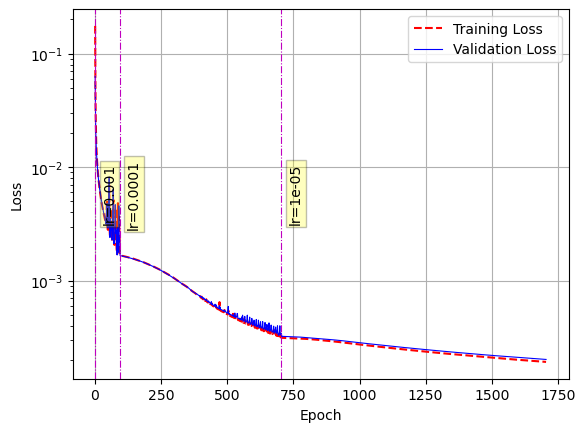

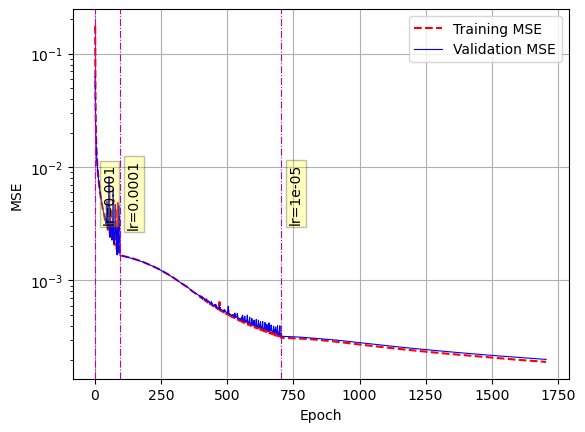

<Figure size 640x480 with 0 Axes>

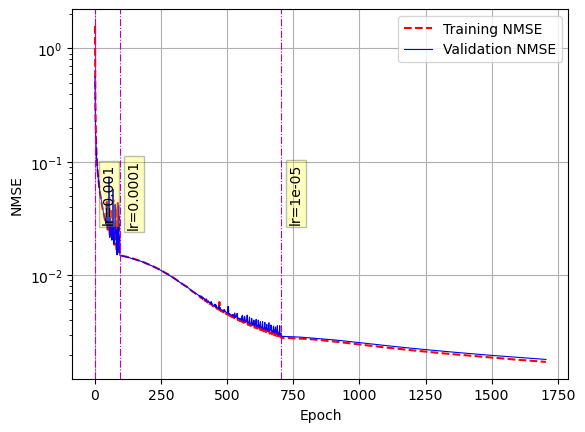

<Figure size 640x480 with 0 Axes>

In [45]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


fig, ax = plot_losses(
    training_loss=train_MSE_hist,
    val_loss=val_MSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training MSE', 'Validation MSE'],
    xlabel='Epoch',
    ylabel='MSE',
)
plt.savefig(dir_name_plot+'/MSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_NMSE_hist,
    val_loss=val_NMSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training NMSE', 'Validation NMSE'],
    xlabel='Epoch',
    ylabel='NMSE',
)
plt.savefig(dir_name_plot+'/NMSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


In [46]:
# data_type = 'training'
rnn_net.reset_states()
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])



data_idx : 29


In [47]:
prediction.shape, data_out.shape, rnn_net.stateful

((16, 100, 1, 13, 13), (100, 1, 13, 13), True)

In [48]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    # for i in range(data.shape[-1]):
    #     new_data[:, i] -= normalization_arr[0, i]
    #     new_data[:, i] /= normalization_arr[1, i]
    new_data -= normalization_arr[0]
    new_data *= normalization_arr[1]
    
    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = data.copy()
    shape = new_data.shape
    # for i in range(shape[-1]):
    #     if len(shape) == 2:
    #         new_data[:, i] *= normalization_arr[1, i]
    #         new_data[:, i] += normalization_arr[0, i]
    #     elif len(shape) == 3:
    #         new_data[:, :, i] *= normalization_arr[1, i]
    #         new_data[:, :, i] += normalization_arr[0, i]
    new_data *= normalization_arr[1]
    new_data += normalization_arr[0]
    return new_data

In [49]:
lyapunov_time_arr = [1/0.065]

In [50]:
normalization_arr

array([[-0.7499788 , -0.7498613 , -0.74918306, -0.74818593, -0.74709743,
        -0.74625283, -0.7458057 , -0.7456656 , -0.7459548 , -0.74685055,
        -0.74789417, -0.7488208 , -0.7495427 , -0.74932796, -0.7491606 ,
        -0.74844015, -0.7474818 , -0.7467681 , -0.74608016, -0.74552155,
        -0.7454448 , -0.74567986, -0.7464409 , -0.7475862 , -0.74854803,
        -0.7491308 , -0.748854  , -0.74867165, -0.7480509 , -0.74722487,
        -0.74631286, -0.74560803, -0.74520135, -0.74532217, -0.7458373 ,
        -0.7464164 , -0.74719167, -0.74771756, -0.74834645, -0.7483056 ,
        -0.74854594, -0.74815845, -0.74714154, -0.74580866, -0.7449367 ,
        -0.74464566, -0.7446485 , -0.7449305 , -0.7454133 , -0.7462478 ,
        -0.7470165 , -0.7477161 , -0.74833983, -0.74815416, -0.7475827 ,
        -0.7468359 , -0.7460861 , -0.7454329 , -0.74501   , -0.74485224,
        -0.7448271 , -0.74547684, -0.74661225, -0.7474208 , -0.7479944 ,
        -0.74845165, -0.74834615, -0.74777526, -0.7

# Autoregressive Mode

In [51]:
temp1 = np.empty_like(testing_data_rnn_input)
temp2 = np.empty_like(testing_data_rnn_output)

begin_idx = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( (1-test_split-val_split)*num_samples )
    # num_val = int(val_split*num_samples)
    num_samples = num_samples_arr[i]
    num_test = num_test_arr[i]

    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        temp1[testing_data_rolling_count + j*nbatches_test:testing_data_rolling_count + (j+1)*nbatches_test] = testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size]
        temp2[testing_data_rolling_count + j*nbatches_test:testing_data_rolling_count + (j+1)*nbatches_test] = testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size]

    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

In [52]:
testing_data_rnn_input_og = testing_data_rnn_input
testing_data_rnn_output_og = testing_data_rnn_output

testing_data_rnn_input = temp1
testing_data_rnn_output = temp2

In [53]:
s_in = testing_data_rnn_input.shape
testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])
# testing_data_rnn_input = testing_data_rnn_input.reshape((s_in[0], s_in[1]) + s_in[2:])

s_out = testing_data_rnn_output.shape
testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])
# testing_data_rnn_output = testing_data_rnn_output.reshape((s_out[0], s_out[1]) + s_out[2:])

In [54]:
T_sample_input_AR = 1*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = 10*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx : 0
data_idx : 2047
data_.shape : (1, 677, 1, 13, 13)


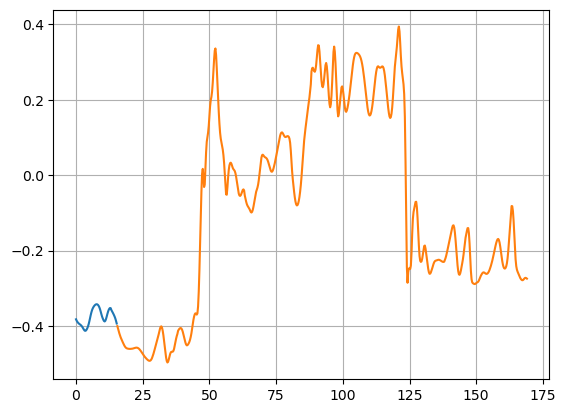

In [55]:
# data_to_consider = 'training'
data_to_consider = 'testing'

data_in = eval(data_to_consider+'_data_rnn_input')
data_out = eval(data_to_consider+'_data_rnn_output')

batch_idx = np.random.randint(low=0, high=data_in.shape[0])
maxpossible_num_runs = data_in.shape[1]-(num_sample_input_AR+num_sample_output_AR)

data_idx = np.random.randint(low=0, high=maxpossible_num_runs)

print('batch_idx : {}'.format(batch_idx))
print('data_idx : {}'.format(data_idx))
data_ = data_in[batch_idx:batch_idx+1, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR), :]
print('data_.shape :', data_.shape)

plt.plot(
    dt_rnn*np.arange(num_sample_input_AR),
    data_[0, 0:num_sample_input_AR, 0, 0, 0])
plt.plot(
    dt_rnn*num_sample_input_AR+dt_rnn*np.arange(num_sample_output_AR),
    data_[0, num_sample_input_AR:, 0, 0, 0])
plt.grid(True)
plt.show()

In [56]:
prediction_lst = []

for layer in rnn_net.rnn_list:
    if layer.stateful == True:
        layer.reset_states()

if data_.shape[0] != batch_size:
    data_ = np.tile(data_, (batch_size,)+tuple([1]*len(data_.shape[1:])))
input_preds = np.array(rnn_net(data_[:, 0:num_sample_input_AR]))

prediction_lst.append(input_preds[:, -1:])

for i in range(1, num_sample_output_AR):
    data_in_i = np.array(prediction_lst[-1])
    output = np.array(rnn_net(data_in_i, training=False))
    prediction_lst.append(output[:, 0:1])

2023-02-20 11:40:55.753026: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-20 11:40:55.753090: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


In [57]:
prediction_lst = np.stack(prediction_lst)[:, 0, 0]
input_preds = input_preds[0]

print('input_preds.shape : {}'.format(input_preds.shape))
print('prediction_lst.shape : {}'.format(prediction_lst.shape))

input_preds.shape : (62, 1, 13, 13)
prediction_lst.shape : (615, 1, 13, 13)


In [58]:
input_preds = input_preds.reshape(input_preds.shape[0], -1)
prediction_lst = prediction_lst.reshape(prediction_lst.shape[0], -1)

print('input_preds.shape : {}'.format(input_preds.shape))
print('prediction_lst.shape : {}'.format(prediction_lst.shape))

input_preds.shape : (62, 169)
prediction_lst.shape : (615, 169)


Only plotting the first 32 latent states because of memory constraints.
0.195


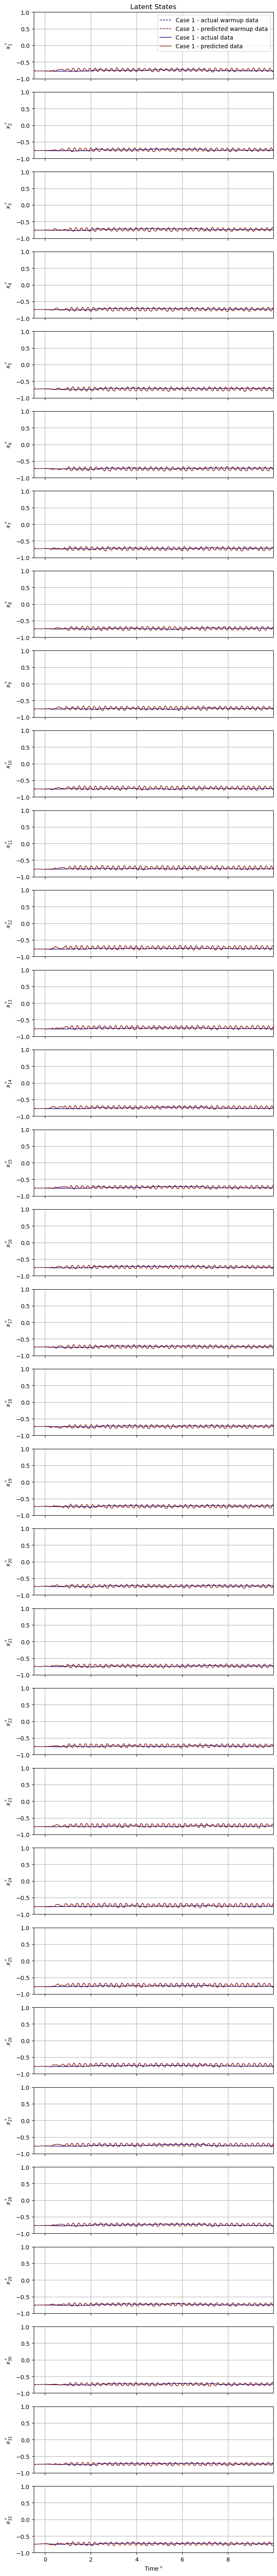

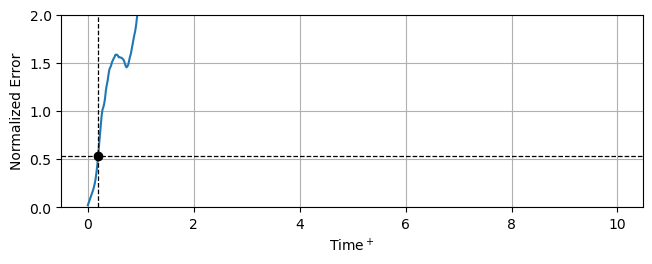

In [59]:
lyap_time = (1/0.065)# np.mean(lyapunov_time_arr)

n = 1
num_latent_states = 32#input_preds.shape[-1]# *input_preds.shape[-2]*input_preds.shape[-3]
N = num_sample_output_AR#num_output_timesteps

if num_latent_states != input_preds.shape[-1]:
    print('Only plotting the first {} latent states because of memory constraints.'.format(num_latent_states))

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = [r'$x^*_{'+str(i+1)+'}$' for i in range(num_latent_states)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

time_arr_warmup1 = (np.arange(num_sample_input_AR) - num_sample_input_AR)*dt_rnn
time_arr_warmup2 = time_arr_warmup1 + dt_rnn

time_arr_warmup1 /= lyap_time
time_arr_warmup2 /= lyap_time

input_time = time_arr_warmup2[-1]+np.arange(N, dtype=float)*dt_rnn/lyap_time

temp_ = data_[0, 0:num_sample_input_AR+N]
temp_ = temp_.reshape(temp_.shape[0], -1)
temp_ = invert_normalization(temp_, normalization_arr)
prediction_lst = invert_normalization(prediction_lst, normalization_arr)
input_preds = invert_normalization(input_preds, normalization_arr)
for j in range(num_latent_states):
    for i in range(n):
        ax[j].plot(time_arr_warmup1, temp_[:num_sample_input_AR, j], linestyle='--', linewidth=1, color=colors[2*i], label='Case {} - actual warmup data'.format(i+1))
        ax[j].plot(time_arr_warmup2, input_preds[:, j], linestyle='--', linewidth=1, color=colors[2*i+1], label='Case {} - predicted warmup data'.format(i+1))
        ax[j].plot(input_time, temp_[num_sample_input_AR:num_sample_input_AR+N, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        ax[j].plot(input_time, prediction_lst[:, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
    ax[j].set_ylabel(ax_ylabels[j])
    ax[j].grid(True)
    ax[j].set_axisbelow(True)
    ax[j].set_ylim([-1, 1])
    ax[j].set_xlim([input_time[0] - 0.5, input_time[-1]])


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(rnn_data_boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)


### error computation
error = (temp_[num_sample_input_AR:num_sample_input_AR+N, :] - prediction_lst[:, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev_AEproducedlatentstates**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if len(predhor_idx.shape) == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.set_ylim([0, 2])

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

In [60]:
try:
    if use_weights_post_dense == True:
        print(rnn_net.postWout.individual_weights)
except:
    pass

### Prediction horizon computation

In [61]:
def plot_histogram_and_save(
    prediction_horizon_arr,
    save_dir,
    savefig_fname='pre_ARtraining',
    bin_width=0.05,
    bin_begin=0.0):
    
    fig, ax = plt.subplots()

    ph_mean = np.mean(prediction_horizon_arr)
    ph_stddev = np.std(prediction_horizon_arr)
    ph_max = np.max(prediction_horizon_arr)
    ph_min = np.min(prediction_horizon_arr)
    
    bin_end = bin_width*np.round((np.max(prediction_horizon_arr)+0.5*bin_width)//bin_width)
    nbins = int(np.round(bin_end/bin_width))

    ax.hist(prediction_horizon_arr, bins=nbins, range = [bin_begin, bin_end], density=True)
    ax.axvline(ph_mean, linewidth=0.9, linestyle='--', color='k')

    ax.set_xlabel('Prediction Horizon (Lyapunov times)')
    ax.set_ylabel('PDF')

    ax.grid(True)
    # ax.set_axisbelow(True)

    ax.text(
        0.01 + ax.transAxes.inverted().transform(ax.transData.transform([prediction_horizon, 0]))[0],
        0.8,
        'mean',
        rotation=90,
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(facecolor=np.array([255,255,153])/255, alpha=1, boxstyle='square,pad=0.2'),
        transform=ax.transAxes
    )

    text_xy = [0.95, 0.95]
    ax.text(
        text_xy[0],
        text_xy[1],
        'mean : {:.4f}\nmax : {:.4f}\nmin : {:.4f}\nstddev : {:.4f}'.format(
            ph_mean,
            ph_max,
            ph_min,
            ph_stddev,
        ),
        transform=ax.transAxes,
        bbox=dict(
            boxstyle="round",
            ec=(0.6, 0.6, 1),
            fc=(0.9, 0.9, 1),
        ),
        # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
        horizontalalignment='right',
        verticalalignment='top'
    )

    ax.set_title('nbins = {}'.format(nbins))
    
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    fig.savefig(save_dir+'/'+savefig_fname+'.png', dpi=300, bbox_inches='tight')
    fig.clear()
    plt.close()

In [62]:
normalization_arr.shape, time_stddev.shape

((2, 169), (1, 13, 13))

In [63]:
num_runs = 100
num_runs = np.min([num_runs, maxpossible_num_runs])
print('num_runs : {}'.format(num_runs))

num_runs : 100


In [64]:
data_idx_arr = np.linspace(0, maxpossible_num_runs-1, num_runs, dtype=np.int32)

savefig_fname = 'pre_ARtraining-'+data_to_consider+'data'
npsavedata_fname = '/prediction_horizons-'+data_to_consider+'data'
plot_dir = '/plots'

analysis_time = time.time()

sidx1 = dir_name_rnn[::-1].index('/')
sidx2 = dir_name_rnn[-sidx1-2::-1].index('/')
print(dir_name_rnn[-(sidx1+sidx2+1):])

prediction_horizon_arr = np.empty(shape=num_runs)

jj_max = int(num_runs // batch_size)
data_ = np.empty(shape=(batch_size, num_sample_input_AR+num_sample_output_AR)+tuple(data_in.shape[2:]))
for jj in range(jj_max):
    data_idxs = data_idx_arr[batch_size*jj:batch_size*(jj+1)]

    # for j in range(len(rnn_data_boundary_idx_arr)):
    #     if data_idx < rnn_data_boundary_idx_arr[j]:
    #         case_idx = j
    #         break
    lyap_time = (1/0.065)#lyapunov_time_arr[0]

    ### picking the data
    for i in range(batch_size):
        data_[i] = data_in[0, data_idxs[i]:data_idxs[i]+(num_sample_input_AR+num_sample_output_AR)]

    ### doing the predictions
    prediction_lst = []

    for layer in rnn_net.rnn_list:
        layer.reset_states()

    input_preds = np.array(rnn_net(data_[:, 0:num_sample_input_AR], training=False))

    prediction_lst.append(input_preds[:, -1:])

    for j in range(1, num_sample_output_AR):
        data_in_j = np.array(prediction_lst[-1])
        output = np.array(rnn_net(data_in_j, training=False))
        prediction_lst.append(output)
    prediction_lst = np.stack(prediction_lst)[:, :, 0]
    prediction_lst = np.transpose(prediction_lst, (1, 0, 2, 3, 4))
    prediction_lst = prediction_lst.reshape(prediction_lst.shape[0], prediction_lst.shape[1], -1)
    prediction_lst = invert_normalization(prediction_lst, normalization_arr) # don't invert if using time_stddev in error
    
    data_out = data_[:, num_sample_input_AR:num_sample_input_AR+num_sample_output_AR]
    data_out = data_out.reshape(data_out.shape[0], data_out.shape[1], -1)
    data_out = invert_normalization(data_out, normalization_arr)

    ### Error and prediction horizon
    # error = np.linalg.norm(data_out[:, :] - prediction[i, :, :], axis=1)
    error = (data_out - prediction_lst)**2
    # error /= norm_sq_time_average(data_out)**0.5
    error = error / time_stddev_AEproducedlatentstates**2
    error = np.mean(error, axis=-1)**0.5

    for i in range(batch_size):
        predhor_idx = np.where(error[i] >= error_threshold)[0]
        if predhor_idx.shape[0] == 0:
            predhor_idx = error.shape[1]
        else:
            predhor_idx = predhor_idx[0]

        prediction_horizon_arr[jj*batch_size+i] = predhor_idx*dt_rnn/lyap_time

if num_runs > jj_max*batch_size:
    for jj in range(jj_max*batch_size, num_runs):
        data_idx = data_idx_arr[jj]

        # for j in range(len(rnn_data_boundary_idx_arr)):
        #     if data_idx < rnn_data_boundary_idx_arr[j]:
        #         case_idx = j
        #         break
        lyap_time = (1/0.065)#lyapunov_time_arr[0]

        ### picking the data
        for i in range(batch_size):
            data_[i] = data_in[0, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR)]

        ### doing the predictions
        prediction_lst = []

        for layer in rnn_net.rnn_list:
            layer.reset_states()

        input_preds = np.array(rnn_net(data_[:, 0:num_sample_input_AR], training=False))

        prediction_lst.append(input_preds[:, -1:])

        for j in range(1, num_sample_output_AR):
            data_in_j = np.array(prediction_lst[-1])
            output = np.array(rnn_net(data_in_j, training=False))
            prediction_lst.append(output)
        prediction_lst = np.stack(prediction_lst)[:, 0, 0]
        prediction_lst = prediction_lst.reshape(prediction_lst.shape[0], -1)
        prediction_lst = invert_normalization(prediction_lst, normalization_arr) # don't invert if using time_stddev in error

        data_out = data_[0, num_sample_input_AR:num_sample_input_AR+num_sample_output_AR]
        data_out = data_out.reshape(data_out.shape[0], -1)
        data_out = invert_normalization(data_out, normalization_arr)

        ### Error and prediction horizon
        # error = np.linalg.norm(data_out[:, :] - prediction[i, :, :], axis=1)
        error = (data_out - prediction_lst)**2
        # error /= norm_sq_time_average(data_out)**0.5
        error = error / time_stddev_AEproducedlatentstates**2
        error = np.mean(error, axis=-1)**0.5

        predhor_idx = np.where(error >= error_threshold)[0]
        if predhor_idx.shape[0] == 0:
            predhor_idx = error.shape[0]
        else:
            predhor_idx = predhor_idx[0]

        prediction_horizon_arr[jj] = predhor_idx*dt_rnn/lyap_time
        
median_idx = int(np.round(0.5*num_runs-1))
quartile_1_idx = int(np.round(0.25*num_runs-1))
quartile_3_idx = int(np.round(0.75*num_runs-1))

prediction_horizon_arr.sort()

median = prediction_horizon_arr[median_idx]
quartile_1 = prediction_horizon_arr[quartile_1_idx]
quartile_3 = prediction_horizon_arr[quartile_3_idx]
IQR = quartile_3 - quartile_1

prediction_horizon = np.mean(prediction_horizon_arr)
stddev_ph = np.std(prediction_horizon_arr)

s = 'error_threshold = {}\n'.format(error_threshold)
s += 'prediction_horizon : {}, median : {}\n'.format(prediction_horizon, median)
s += 'ph_min : {}, ph_max : {}\n'.format(prediction_horizon_arr.min(), prediction_horizon_arr.max())
s += 'stddev : {}, IQR : {}\n'.format(stddev_ph, IQR)
s += '1st quartile : {}, 3rd quartile : {}'.format(quartile_1, quartile_3)

print('\n'+s)

plot_histogram_and_save(
    prediction_horizon_arr,
    save_dir=dir_name_rnn+plot_dir,
    savefig_fname=savefig_fname
)

npsavedata_fname = '/prediction_horizons-'+data_to_consider+'data'
np.savez(
    dir_name_rnn+npsavedata_fname,
    prediction_horizon_arr=prediction_horizon_arr,
    error_threshold=error_threshold,
)

with open(dir_name_rnn+npsavedata_fname+'--statistics.txt', 'w') as fl:
    fl.write(s)

print('analysis time : {} s\n'.format(time.time() - analysis_time))

saved_ConvESN/ESN_007

error_threshold = 0.5
prediction_horizon : 0.16315, median : 0.1625
ph_min : 0.065, ph_max : 0.24375000000000002
stddev : 0.03838028465240976, IQR : 0.04874999999999999
1st quartile : 0.14625000000000002, 3rd quartile : 0.195
analysis time : 88.8348913192749 s

